# Rating Prediction of Cafe on Google Maps

## Datasets

In [158]:
import os
import json
import gzip
from functools import partial
from datetime import datetime, timezone
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from shapely.geometry import shape, Point
from shapely.prepared import prep
from functools import lru_cache

import requests
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

import ast
import geopandas as gpd
from shapely.geometry import Point

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(0)

### Downloading Dataset

In [159]:
meta_path = "./datasets/raw/meta-California.json.gz"
meta_keys = ["gmap_id", "name", "latitude", "longitude", "category", "avg_rating", "num_of_reviews", "price", "hours"]

review_path = "./datasets/raw/review-California.json.gz"
review_keys = ["gmap_id", "user_id", "name", "time", "rating"]

total_reviews = 70529977

In [160]:
def download_meta_data():
    url = "https://mcauleylab.ucsd.edu/public_datasets/gdrive/googlelocal/meta-California.json.gz"
    res = requests.get(url, stream=True)

    with open(meta_path, "wb") as f:
        f.write(res.content)

In [161]:
def download_review_data():
    url = "https://mcauleylab.ucsd.edu/public_datasets/gdrive/googlelocal/review-California.json.gz"
    res = requests.get(url, stream=True)

    with open(review_path, "wb") as f:
        f.write(res.content)

In [162]:
os.makedirs("./datasets/raw", exist_ok=True)
os.makedirs("./datasets/processed", exist_ok=True)

if not os.path.exists(meta_path):
    download_meta_data()

if not os.path.exists("./datasets/raw/review-California.json.gz"):
    download_review_data()

### Processing Dataset

In [163]:
def parse(path):
    g = gzip.open(path, "r")
    for l in g:
        yield json.loads(l)

Processing business data to extract Cafes we want to focus on.

In [164]:
# I reused my code from COGS108 project to process dataset.

def get_cafe_categories():
    categories = []
    for business in parse(meta_path):
        if business["category"] is not None:
            categories += business["category"]

    categories = np.array(categories)
    unique = np.unique(categories)

    cafe_categories = [str(category) for category in unique if "cafe" in category.lower() or "coffee" in category.lower()]
    print(f"The number of categories containting 'cafe' substring is {len(cafe_categories)}")
    print(cafe_categories)

    with open(f"./datasets/processed/cafe_categories.txt", "w") as f:
        f.write("\n".join(cafe_categories))

def filter_by_category(data, categories):
    category = data.get("category", None)
    if category is None:
        return False

    return len(set(category) & categories) != 0

def filter_by_num_reviews(data, min_num_reviews):
    return data["num_of_reviews"] >= min_num_reviews

def filter_raw_business_data(filters):
    businesses = []
    for business in parse(meta_path):
        if all([f(data=business) for f in filters]):
            business = {key: business.get(key, None) for key in meta_keys}
            businesses.append(business)

    print(f"We obtained total of {len(businesses)} after filtering")

    df = pd.DataFrame(businesses)
    df.to_csv(f"./datasets/processed/cafes.csv", index=False)

In [165]:
if not os.path.exists("./datasets/processed/cafe_categories.txt"):
        get_cafe_categories()

if not os.path.exists("./datasets/processed/cafes.csv"):
    min_num_reviews = 100

    with open("./datasets/processed/cafe_categories.txt", "r") as f:
        cafe_categories = set(f.read().split("\n"))

    cafe_filter = partial(filter_by_category, categories=cafe_categories)
    num_reviews_filter = partial(filter_by_num_reviews, min_num_reviews=min_num_reviews)

    filter_raw_business_data([cafe_filter, num_reviews_filter])

Processing review data to extract reviews we want to focus on.

In [166]:
# I reused my code from COGS108 project to process dataset.

def filter_by_gmap_id(data, gmap_ids):
    gmap_id = data.get("gmap_id", None)
    if gmap_id is None:
        return False

    return gmap_id in gmap_ids

def filter_raw_review_data(filters):
    reviews = []

    for review in tqdm.tqdm(parse(review_path), total=total_reviews):
        if all([f(data=review) for f in filters]):
            review = {key: review.get(key, None) for key in review_keys}
            review["review_id"] = f"{review['user_id']}_{review['gmap_id']}"
            reviews.append(review)

    print(f"We obtained total of {len(reviews)} after filtering")
    df = pd.DataFrame(reviews)
    df.to_csv("./datasets/raw/cafe_reviews.csv", index=False)

def extract_user_ids(reviews, min_num_reviews):
    user_ids = reviews["user_id"].dropna().values
    unique, counts = np.unique(np.array(user_ids), return_counts=True)
    users = pd.DataFrame({"user_id": unique, "num_reviews": counts})

    users = users[users["num_reviews"] >= min_num_reviews].reset_index(drop=True)
    print(f"We extracted {users.shape[0]} users after filtering.")

    users.to_csv("./datasets/processed/users.csv", index=False)

def filter_by_user_ids(reviews, user_ids):
    reviews = reviews[reviews["user_id"].isin(user_ids)]

    print(f"We extracted {reviews.shape[0]} reviews after filtering.")
    reviews.to_csv("./datasets/processed/reviews.csv", index=False)

In [167]:
if not os.path.exists("./datasets/raw/cafe_reviews.csv"):
    gmap_ids = set(pd.read_csv("./datasets/processed/cafes.csv")["gmap_id"].values)
    gmap_id_filter = partial(filter_by_gmap_id, gmap_ids=gmap_ids)
    filter_raw_review_data([gmap_id_filter])

if not os.path.exists("./datasets/processed/users.csv"):
    print("Start processing user data")
    reviews = pd.read_csv("./datasets/raw/cafe_reviews.csv")
    min_num_reviews = 20
    extract_user_ids(reviews, min_num_reviews)

if not os.path.exists("./datasets/processed/reviews.csv"):
    print("Start filtering review data")
    reviews = pd.read_csv("./datasets/raw/cafe_reviews.csv")
    user_ids = pd.read_csv("./datasets/processed/users.csv")["user_id"].values
    filter_by_user_ids(reviews, user_ids)

Split dataset into train, validation, and test so that we can evaluate models with unseen data. However, due to the design of the model which relies on pre-defined list of user and cafes, we need to split randomly without stratifying based on users or cafes.

In [168]:
def split_reviews():
    file_name = "./datasets/processed/reviews.csv"
    reviews = pd.read_csv(file_name).sample(frac=1, random_state=42)

    valid_size = int(reviews.shape[0] * 0.1)
    test_size = int(reviews.shape[0] * 0.1)

    valid_reviews = reviews.iloc[:valid_size].reset_index(drop=True)
    test_reviews = reviews.iloc[valid_size: valid_size + test_size].reset_index(drop=True)
    train_reviews = reviews.iloc[valid_size + test_size:].reset_index(drop=True)

    print(f"train: {train_reviews.shape[0]} / valid: {valid_reviews.shape[0]} / test: {test_reviews.shape[0]}")

    os.makedirs("./datasets/splits", exist_ok=True)

    train_reviews.to_csv("./datasets/splits/train.csv", index=False)
    valid_reviews.to_csv("./datasets/splits/valid.csv", index=False)
    test_reviews.to_csv("./datasets/splits/test.csv", index=False)

In [169]:
if not os.path.exists("./datasets/splits/train.csv"):
    split_reviews()

### EDA

### Overview

### Review Time

In [170]:
# One Hot Encoding for Unix Time Weekday
def unix_weekday_to_onehot(time):
    feature_weekday = [0]*7

    day = datetime.fromtimestamp(time / 1000, tz=timezone.utc).weekday()
    feature_weekday[day] = 1.

    return feature_weekday

# One Hot Encoding for Unix Time Hour
def unix_hour_to_onehot(time):
    feature_dayhour = [0]*24

    hr = datetime.fromtimestamp(time / 1000, tz=timezone.utc).hour
    feature_dayhour[hr] = 1.

    return feature_dayhour

### Review Period

In [171]:
# One Hot Encoding for Period
def unix_period_to_onehot(unix_ms):
    """
      0 -> before 2016
      1 -> 2016-2019
      2 -> 2020 and later
    """
    if pd.isna(unix_ms):
        return np.nan
    try:
        t = int(unix_ms)
    except (ValueError, TypeError):
        return np.nan

    b2016_ms = int(pd.Timestamp("2016-01-01").timestamp() * 1000)
    b2020_ms = int(pd.Timestamp("2020-01-01").timestamp() * 1000)

    if t < b2016_ms:
        return [0, 0, 0]
    elif t < b2020_ms:
        return [0, 1., 0]
    else:
        return [0, 0, 1.]

### Chain

In [172]:
def get_chains_dict(cafes):
    names, counts = np.unique(cafes["name"], return_counts=True)
    indices = np.argsort(counts)[::-1]
    sorted_counts = counts[indices]
    sorted_names = names[indices]

    stems = defaultdict(int)
    for name in sorted_names:
        words = name.lower().strip().split()

        for i in range(len(words)):
            stems[" ".join(words[:(i+1)])] += 1

    chains = {}
    for name, count in zip(sorted_names, sorted_counts):
        if count > 5:
            chains[name] = 2
            continue

        words = name.lower().strip().split()
        stem_matches = []
        for i in range(len(words)):
            stem_matches.append(stems[" ".join(words[:(i+1)])])

        if len(stem_matches) == 1 or len(stem_matches) > 10:
            chains[name] = 0
            continue

        if len(stem_matches) >= 2 and sum(stem_matches[1:]) < 10:
            chains[name] = 0
            continue

        if len(stem_matches) >= 3 and sum(stem_matches[2:]) < 5:
            chains[name] = 0
            continue

        chains[name] = 1

    return chains

### Price

In [173]:
# One Hot Encoding for Price
def price_to_onehot(price):
    feature_price = [0]*4
    if price is not np.nan:
        feature_price[len(price)-1] += 1.
    return feature_price

### Open Hours

In [174]:
# Converts time text to values
def parse_time(t):
    t = t.strip().upper()

    # Match hh or hh:mm formats
    m = re.match(r"(\d{1,2})(?::(\d{2}))?(AM|PM)", t)
    if not m:
        raise ValueError(f"Invalid time format: {t}")

    hour = int(m.group(1))
    minute = int(m.group(2) or 0)
    period = m.group(3)

    # Convert to 24-hour
    if period == "AM":
        if hour == 12:
            hour = 0
    else:  # PM
        if hour != 12:
            hour += 12

    return hour + minute / 60.0

# One Hot Encoding for Open Hours
def hours_to_onehot(hour_str):
    if hour_str is None or hour_str is np.nan:
        return [0,0,0]
    before_noon = 0
    after_noon = 0
    hours = ast.literal_eval(hour_str)

    for entry in hours:
        if entry[1] == "Open 24 hours":
            return [1.,0,0]
        if entry[1] == "Closed":
            continue

        open_str, close_str = entry[1].split("–")
        try:
            start_hr = int(np.floor(parse_time(open_str)))
        except ValueError:
            return [0,0,0]
        if start_hr < 13:
            before_noon += 1.
        else: after_noon += 1.

    if before_noon > after_noon:
        return [0,1.,0]
    return [0,0,1.]

### Location

In [175]:
@lru_cache(maxsize=1)
def get_counties_ca():
    counties = gpd.read_file("resources/cb_2018_us_county_500k.shp")
    counties_ca = counties[counties["STATEFP"] == "06"]  # California only
    counties_ca = counties_ca.sort_values("NAME").reset_index(drop=True)
    counties_ca["COUNTY_NUM"] = counties_ca.index
    counties_ca = counties_ca.set_geometry("geometry")
    _ = counties_ca.sindex
    return counties_ca

def get_county(lat, lon):
    counties_ca = get_counties_ca()
    point = Point(lon, lat)  # geometry expects (lon, lat)
    idx = list(counties_ca.sindex.intersection(point.bounds))
    if not idx:
        return None
    candidates = counties_ca.iloc[idx]
    matches = candidates[candidates.contains(point)]
    return int(matches.iloc[0]["COUNTY_NUM"]) if len(matches) else None

def location_to_onehot(location):
    feature_county =[0]*58  # 58 counties in Cali

    if location is not None:
        feature_county[location] = 1.

    return feature_county

### User History

## Modeling

### Feature Matrix Consturction

We construct dictionaries converting the following:
- `user_id` to index of onehot vector for user.
- `gmap_id` to index of onehot vector for cafe.
- `price` to onehot vector for cafe price.
- `hours` to onehot vector for whether a cafe is open all day, morning, or evening.
- `latitude` and `longitude` to index of onehot vector for counties in California.
- `chains` to onehot vector for size of chain (none, small, large).
- `prev` to index of onehot vector for cafe that user previously rated.

In [176]:
def preprocess_data_latent(feat_names):
    reviews = pd.read_csv("./datasets/processed/reviews.csv")
    cafes = pd.read_csv("./datasets/processed/cafes.csv")

    feat_dicts = {}
    for name in feat_names:
        if name == "user":
            unique_user_ids = np.sort(np.unique(reviews["user_id"].values))
            user2index = {user_id: index for index, user_id in enumerate(unique_user_ids)}
            feat_dicts[name] = user2index

        elif name == "cafe":
            unique_gmap_ids = np.sort(np.unique(cafes["gmap_id"]))
            cafe2index = {gmap_id: index for index, gmap_id in enumerate(unique_gmap_ids)}
            feat_dicts[name] = cafe2index

        elif name == "price":
            unique_gmap_ids, indices = np.unique(cafes["gmap_id"], return_index=True)
            order = np.argsort(unique_gmap_ids)
            unique_gmap_ids = unique_gmap_ids[order]
            indices = indices[order]
            cafe2price = {gmap_id: cafes["price"][index] for gmap_id, index in zip(unique_gmap_ids, indices)}
            feat_dicts[name] = cafe2price

        elif name == "open_hours":
            unique_gmap_ids, indices = np.unique(cafes["gmap_id"], return_index=True)
            order = np.argsort(unique_gmap_ids)
            unique_gmap_ids = unique_gmap_ids[order]
            indices = indices[order]
            cafe2hours = {gmap_id: cafes["hours"][index] for gmap_id, index in zip(unique_gmap_ids, indices)}
            feat_dicts[name] = cafe2hours

        elif name == "location":
            unique_gmap_ids, indices = np.unique(cafes["gmap_id"], return_index=True)
            order = np.argsort(unique_gmap_ids)
            unique_gmap_ids = unique_gmap_ids[order]
            indices = indices[order]
            cafe2location = {gmap_id: get_county(cafes["latitude"][index],cafes["longitude"][index]) for gmap_id, index in zip(unique_gmap_ids, indices)}
            feat_dicts[name] = cafe2location

        elif name == "chains":
            unique_gmap_ids, indices = np.unique(cafes["gmap_id"], return_index=True)
            order = np.argsort(unique_gmap_ids)
            unique_gmap_ids = unique_gmap_ids[order]
            indices = indices[order]

            chains = get_chains_dict(cafes)
            cafe2chain = {gmap_id: chains[cafes["name"][index]] for gmap_id, index in zip(unique_gmap_ids, indices)}
            feat_dicts[name] = cafe2chain

        elif name == "prev":
            reviews_sorted = reviews.sort_values(by=['user_id', 'time'])

            user_interactions = (
                reviews_sorted.groupby('user_id')['gmap_id']
                .apply(list)
                .to_dict()
            )

            feat_dicts[name] = user_interactions

    avg_rating = reviews["rating"].mean()

    return feat_dicts, avg_rating

Then, we construct PyTorch Dataset. This class is desgined to be flexible about which features that are used. It receives a list of feature names in `feat_names` that will be used in the model and uses `feat_dicts` to map data to onehot vector. The following features that can be used are:
- `alpha` is a bias term and we initialize it with global average of rating.
- `user` is a user of a review.
- `cafe` is a cafe of a review.
- `weekday` is a weekday of a week when a review was posted.
- `hour` is an hour of a day when a review was posted.
- `price` is the price of the cafe (listed as either $, $$, $$$, or $$$$).
- `open_hours` is the open hours of the cafe.
- `location` is the location (county) of the cafe.
- `chains` is whether a cafe is a large or small chain - or not a chain at all.
- `prev` is the previous cafe the user review.

In [177]:
class CafeDatasetLatent(Dataset):
    def __init__(self, mode, feat_names, feat_dicts):
        self.reviews = pd.read_csv(f"./datasets/splits/{mode}.csv").values

        self.feat_names = feat_names
        self.feat_dicts = feat_dicts

    def get_feat_sizes(self):
        feat_sizes = {}

        for name in self.feat_names:
            if name == "alpha":
                feat_sizes[name] = 1

            elif name == "user":
                feat_sizes[name] = len(self.feat_dicts[name].keys())

            elif name == "cafe":
                feat_sizes[name] = len(self.feat_dicts[name].keys())

            elif name == "weekday":
                feat_sizes[name] = 7

            elif name == "hour":
                feat_sizes[name] = 24

            elif name == "price":
                feat_sizes[name] = 4

            elif name == "open_hours":
                feat_sizes[name] = 3

            elif name == "location":
                feat_sizes[name] = 58

            elif name == "chains":
                feat_sizes[name] = 3

            elif name == "period":
                feat_sizes[name] = 3

            elif name == "prev":
                feat_sizes[name] = len(self.feat_dicts["cafe"].keys())

            else:
                raise NotImplementedError

        return feat_sizes

    def __len__(self):
        return self.reviews.shape[0]

    def __getitem__(self, index):
        review = self.reviews[index]
        feats = []
        for name in self.feat_names:
            if name == "alpha":
                feat = torch.ones(1)
                feats.append(feat)

            elif name == "user":
                feat_dict = self.feat_dicts[name]
                feat = torch.zeros(len(feat_dict.keys()))
                feat[feat_dict[review[1]]] = 1.
                feats.append(feat)

            elif name == "cafe":
                feat_dict = self.feat_dicts[name]
                feat = torch.zeros(len(feat_dict.keys()))
                feat[feat_dict[review[0]]] = 1.
                feats.append(feat)

            elif name == "weekday":
                feat = torch.tensor(unix_weekday_to_onehot(int(review[3])))
                feats.append(feat)

            elif name == "hour":
                feat = torch.tensor(unix_hour_to_onehot(int(review[3])))
                feats.append(feat)

            elif name == "price":
                feat_dict = self.feat_dicts[name]
                feat = torch.tensor(price_to_onehot(feat_dict[review[0]]))
                feats.append(feat)

            elif name == "open_hours":
                feat_dict = self.feat_dicts[name]
                feat = torch.tensor(hours_to_onehot(feat_dict[review[0]]))
                feats.append(feat)

            elif name == "location":
                feat_dict = self.feat_dicts[name]
                feat = torch.tensor(location_to_onehot(feat_dict[review[0]]))
                feats.append(feat)

            elif name == "chains":
                feat_dict = self.feat_dicts[name]
                feat = torch.zeros(3)
                feat[feat_dict[review[0]]] = 1.
                feats.append(feat)

            elif name == "period":
                feat = torch.tensor(unix_period_to_onehot(int(review[3])))
                feats.append(feat)

            elif name == "prev":
                cafe_feat_dict = self.feat_dicts['cafe']    # All cafes
                feat_dict = self.feat_dicts[name]           # List of user -> list of all cafes user rated
                feat = torch.zeros(len(cafe_feat_dict.keys()))
                user = review[1]
                current_item = review[0]
                i = feat_dict[user].index(current_item)     # Get index of current cafe in user list
                if i > 0:
                    prev_item = feat_dict[user][i-1]
                    feat[cafe_feat_dict[prev_item]] = 1.
                feats.append(feat)

            else:
                raise NotImplementedError

        rating = torch.tensor(review[4])

        return *feats, rating

Next, we construct a model for rating prediction. This class is also designed to be flexible and it receives following arguments:
- `name` is a unique identifier of a model.
- `dim` is a dimension of latent.
- `feat_sizes` is a list of feature sizes which would be used to initialize weights.
- `latent_names` is a list of latent feature names which would be used to initialize latents.
- `latent_pairs` is a list of tuples which indicate pairs we would calculate dot product in between.
- `avg_rating` is a global average rating which is used to initialize alpha.
- `share_latents` is indicator used for user history model to share latents for current and previous cafes. 
  
This model has two sets of parameters:
- `weights` is a dictionary of weights for each feature and corresponds to betas in model equation.
- `latents` is a dictionary of latents for feature we specified and corresponds to gammas in model equation.

In [178]:
class RatePredictorLatent(nn.Module):
    def __init__(self, name, dim, feat_sizes, latent_names, latent_pairs, avg_rating, share_latents=False):
        super().__init__()

        self.name = name

        self.feat_names = list(feat_sizes.keys())
        self.latent_names = latent_names
        self.latent_pairs = latent_pairs

        self.share_latents = share_latents

        weights = {}
        for name, feat_size in feat_sizes.items():
            if self.share_latents and name == "prev":
                continue

            if name == "alpha":
                weight = torch.tensor(avg_rating).unsqueeze(0)
            else:
                weight = torch.zeros(feat_size)
            weights[name] = nn.Parameter(weight, requires_grad=True)

        self.weights =  nn.ParameterDict(weights)

        latents = {}
        for name in latent_names:
            feat_size = feat_sizes[name]
            latent = torch.randn(feat_size, dim) / dim
            latents[name] = nn.Parameter(latent, requires_grad=True)

        self.latents = nn.ParameterDict(latents)

    def forward(self, feats):
        out = torch.zeros(feats["alpha"].size(0)).to(feats["alpha"].device)
        for name in self.feat_names:
            if self.share_latents and name == "prev":
                continue

            out += torch.einsum("bd,d->b", feats[name], self.weights[name])

        gammas = {}
        for name in self.latent_names:
            gammas[name] = torch.einsum("bd,di->bi", feats[name], self.latents[name])

        if self.share_latents:
            gammas["prev"] = torch.einsum("bd,di->bi", feats["prev"], self.latents["cafe"])

        for (latent_i, latent_j) in self.latent_pairs:
            out += torch.einsum("bi,bi->b", gammas[latent_i], gammas[latent_j])

        return out


Next, we construct a trainer to train a model by using autograd of PyTorch. 

In [179]:
class RateTrainerLatent():
    def __init__(self, model, lamb_dict, lr, train_dataloader, valid_dataloader, device):
        self.model = model
        self.lamb_dict = lamb_dict
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.device = device

        self.feat_names = model.feat_names
        self.latent_names = model.latent_names

        self.optim =  torch.optim.Adam(model.parameters(), lr=lr)

    def train(self, n_epochs):
        train_mses, valid_mses = [], []
        best_mse = float("inf")
        for i in range(n_epochs):
            train_mse = 0
            total = 0

            bar = tqdm.tqdm(self.train_dataloader, desc="Training Model")
            for feats in bar:
                ratings = feats[-1].to(self.device)
                assert len(self.feat_names) + 1 == len(feats)
                feats = {name: f.to(self.device) for name, f in zip(self.feat_names, feats[:-1])}

                self.optim.zero_grad()

                pred_ratings = self.model(feats)
                mse = self.mse(ratings, pred_ratings)
                mse_reg = mse + self.regularizer()

                mse_reg.backward()
                self.optim.step()

                batch_size = feats["alpha"].size(0)
                train_mse += mse.item() * batch_size
                total += batch_size

                bar.set_description(f"Training Model ({mse.item():.6f})")

            train_mse /= total
            valid_mse = self.validate()
            print(f"Step[{i + 1:2d}]: train {train_mse:2.6f} / valid {valid_mse:2.6f}")

            if valid_mse < best_mse:
                best_mse = valid_mse
                torch.save(self.model, f"./models/{self.model.name}.pt")

            train_mses.append(train_mse)
            valid_mses.append(valid_mse)

        return train_mses, valid_mses

    def validate(self):
        with torch.no_grad():
            total = 0
            mse = 0

            for feats in self.valid_dataloader:
                ratings = feats[-1].to(self.device)
                assert len(self.feat_names) + 1 == len(feats)
                feats = {name: f.to(self.device) for name, f in zip(self.feat_names, feats[:-1])}

                pred_ratings = self.model(feats)

                batch_size = feats["alpha"].size(0)
                mse += self.mse(ratings, pred_ratings).item() * batch_size
                total += batch_size

            return mse / total

    def mse(self, y_true, y_pred):
        return torch.mean((y_true - y_pred) ** 2)

    def regularizer(self):
        reg = 0
        for name in self.feat_names:
            if self.model.share_latents and name == "prev":
                continue

            reg += self.lamb_dict[name] * torch.mean(self.model.weights[name] ** 2)

        for name in self.latent_names:
            latents = self.model.latents[name]
            reg += self.lamb_dict[name] * latents.size(1) * torch.mean(latents ** 2)

        return reg


We record metrics in a file `metrics.json`

In [180]:
def update_metrics(name, train, valid):
    if os.path.exists("./metrics.json"):
        with open("./metrics.json", "r") as f:
           metrics = json.load(f)
    else:
        metrics = {}

    metrics[name] = {"metrics": {"train": train, "valid": valid}}

    with open("./metrics.json", "w") as f:
        json.dump(metrics, f)

After a series of experiments, we ended up using the following hyperparamters for all the experiments below:
- `n_epoch` is the numer of iterations for training.
- `lr` is a learning rate of gradient descent.
- `dim` is a dimension of latents if used.
- `batch_size` is a batch size of training.
- `device` is a device we run models on. You can change "cpu" to "cuda" if you have GPU environment. However, we only tested on "cpu" so we cannot guarantee that it would work on "gpu".

In [181]:
n_epoch = 10
lr = 0.01
dim = 32
batch_size = 2048

device = torch.device("cpu")

Then we define `train` function which train a model given a parameter dictionary called `param_dict` which requires the following keys:
- `feat` is a category of a model where we used "base", "chains", "price", "open_hours", "time", "period", and "prev". We add "_latent" if it uses latents.
- `feat_names` is a list of features that model uses.
- `latent_names` is a list of features that model computes latents for.
- `latent_pairs` is a list of pairs of latent features which model computs dot product for.
- `lamb_dict` is a dictionary which maps feature name to regularizer coefficient for each feature.
- `share_latents` is a indicator if model share latents for current and previous cafe in user history model.

In [182]:
def train(param_dict):
    feat = param_dict["feat"]
    feat_names = param_dict["feat_names"]
    latent_names = param_dict["latent_names"]
    latent_pairs = param_dict["latent_pairs"]
    lamb_dict = param_dict["lamb_dict"]
    share_latents = param_dict.get("share_latents", 0)

    lamb_str = "_".join([f"{name}-{value}" for name, value in lamb_dict.items()])
    name = f"{feat}_{lamb_str}"

    if not os.path.exists(f"./models/{name}.pt"):
        print(f"Start training {name}")

        feat_dicts, avg_rating = preprocess_data_latent(feat_names)
        train_dataset = CafeDatasetLatent("train", feat_names, feat_dicts)
        valid_dataset = CafeDatasetLatent("valid", feat_names, feat_dicts)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

        feat_sizes = train_dataset.get_feat_sizes()
        model = RatePredictorLatent(name, dim, feat_sizes, latent_names, latent_pairs, avg_rating, share_latents=share_latents)

        trainer = RateTrainerLatent(model, lamb_dict, lr, train_dataloader, valid_dataloader, device)

        os.makedirs("./models", exist_ok=True)
        train_mses, valid_mses = trainer.train(n_epoch)

        update_metrics(name, train_mses, valid_mses)

## Running Models to Find Hyper-Parameters

In the following sections, we train models to test if adding specific feature would boost performance and which regularizer coefficient is best for each feature. This would take hours to run so this code won't run training. However, if you want to run training you can set a variable `validation` as `True`.

In [183]:
validation = False

We also load pre-calculated training histories.

In [ ]:
def get_name(param_dict):
    feat = param_dict["feat"]
    lamb_dict = param_dict["lamb_dict"]

    lamb_str = "_".join([f"{name}-{value}" for name, value in lamb_dict.items()])
    name = f"{feat}_{lamb_str}"

    return name

def plot_results(params):
    if not os.path.exists("./metrics.json"):
        return None

    with open("./metrics.json", "r") as f:
        metrics = json.load(f)

    sns.set_theme(style="whitegrid", palette="viridis")
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

    best_mses, categories = [], []
    feat = ""
    for param_dict in params:
        feat = param_dict["feat"]
        name = get_name(param_dict)
        metric = metrics.get(name, None)
        valid_mses = metric["metrics"]["valid"]
        df = pd.DataFrame({"epochs": np.arange(1, n_epoch + 1), "valid": valid_mses})
        sns.lineplot(df, x="epochs", y="valid", label=name, ax=axes[0])

        best_mses.append(min(valid_mses))

        if "base" in feat:
            lamb_dict = param_dict["lamb_dict"]
            categories.append(f"user lamb {lamb_dict["user"]} \ncafe lamb {lamb_dict["cafe"]}")

        elif "time" in feat:
            lamb_dict = param_dict["lamb_dict"]
            categories.append(f"weekday lamb {lamb_dict["weekday"]} \nhour lamb {lamb_dict["hour"]}")

        else:
            lamb_dict = param_dict["lamb_dict"]
            name = "_".join([l for l in feat.split("_") if l != "latent" and l != "all"])
            categories.append(f"{name} lamb {lamb_dict[name]}")



    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Validation MSE")
    axes[0].legend()

    df = pd.DataFrame({"category": categories, "mse": best_mses})
    sns.barplot(df, y="category", x="mse", ax=axes[1])
    axes[1].set_ylabel("Models")
    axes[1].set_xlabel("Best Validation MSE")

    if "base" in feat:
        axes[1].set_xlim(0.67, 0.77)

    else:
        axes[1].set_xlim(0.67, 0.72)

    plt.tight_layout()
    plt.show()


In [185]:
best_params = {}

### Plotting Results
We plot results to compare performance on validation set and see training history.

### Base without Latents

We train a naive model where we only use features of `user_id` and `cafe` without latents.

In [186]:
params = [
    {
        "feat": "base",
        "feat_names": ["alpha", "user", "cafe"],
        "latent_names": [],
        "latent_pairs": [],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1},
        "test": 1
    },
    {
        "feat": "base",
        "feat_names": ["alpha", "user", "cafe"],
        "latent_names": [],
        "latent_pairs": [],
        "lamb_dict": {"alpha": 0, "user": 1, "cafe": 0.1},
        "test": 0
    },
    {
        "feat": "base",
        "feat_names": ["alpha", "user", "cafe"],
        "latent_names": [],
        "latent_pairs": [],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 0.1},
        "test": 0
    },
    {
        "feat": "base",
        "feat_names": ["alpha", "user", "cafe"],
        "latent_names": [],
        "latent_pairs": [],
        "lamb_dict": {"alpha": 0, "user": 1, "cafe": 1},
        "test": 0
    }
]

In [187]:
if validation:
    for param_dict in params:
        train(param_dict)

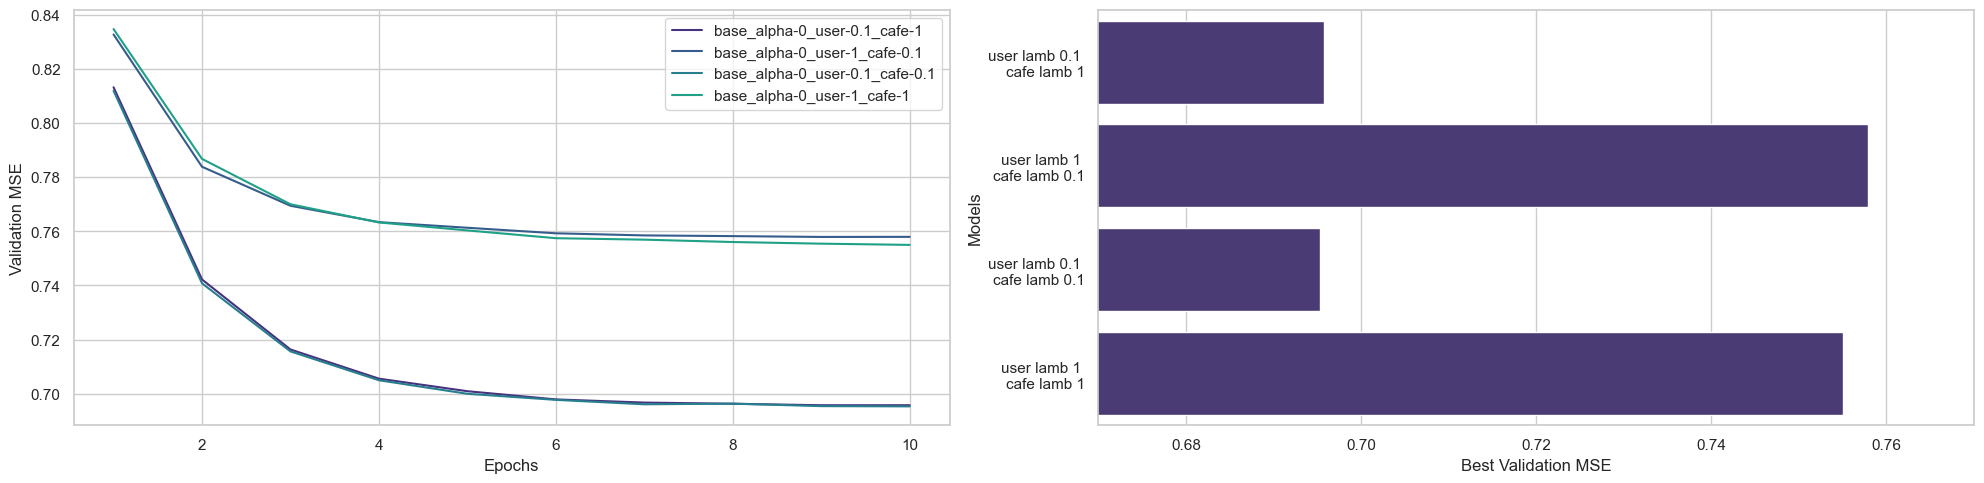

In [188]:
plot_results(params)

In [189]:
best_params["base"] = params[2]

### Base with Latents (User x Cafe)

Next, we train a naive model with latents for `user` and `cafe`.

In [190]:
params = [
    {
        "feat": "base_latent",
        "feat_names": ["alpha", "user", "cafe"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1},
        "test": 1
    },
    {
        "feat": "base_latent",
        "feat_names": ["alpha", "user", "cafe"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 1, "cafe": 0.1},
        "test": 0
    },
    {
        "feat": "base_latent",
        "feat_names": ["alpha", "user", "cafe"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 0.1},
        "test": 0
    },
    {
        "feat": "base_latent",
        "feat_names": ["alpha", "user", "cafe"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 1, "cafe": 1},
        "test": 0
    }
]

In [191]:
if validation:
    for param_dict in params:
        train(param_dict)

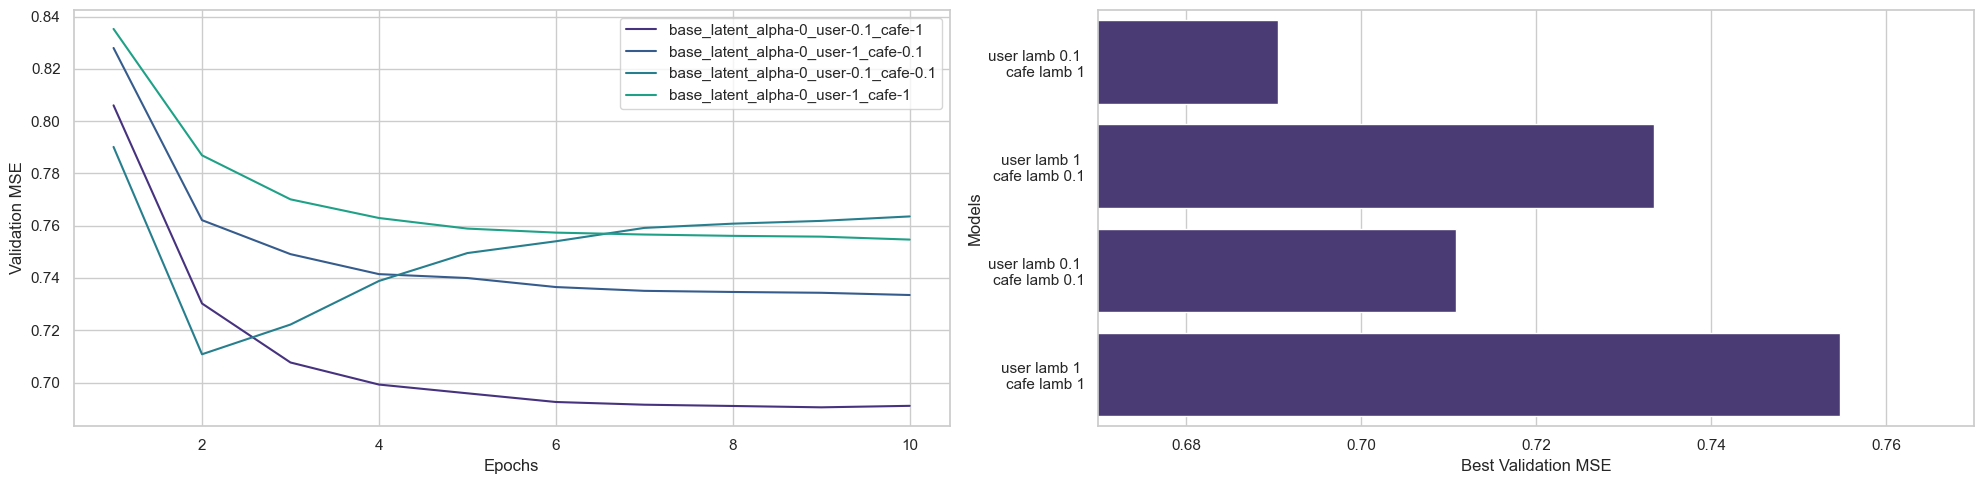

In [192]:
plot_results(params)

In [193]:
best_params["base_latent"] = params[0]

### Review Time without Latents

In [194]:
params = [
    {
        "feat": "time",
        "feat_names": ["alpha", "user", "cafe", "weekday", "hour"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "weekday": 1, "hour": 1},
        "test": 0
    },
    {
        "feat": "time",
        "feat_names": ["alpha", "user", "cafe", "weekday", "hour"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "weekday": 0.1, "hour": 0.1},
        "test": 0
    },
    {
        "feat": "time",
        "feat_names": ["alpha", "user", "cafe", "weekday", "hour"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "weekday": 0.01, "hour": 0.01},
        "test": 0
    }
]

In [195]:
if validation:
    for param_dict in params:
        train(param_dict)

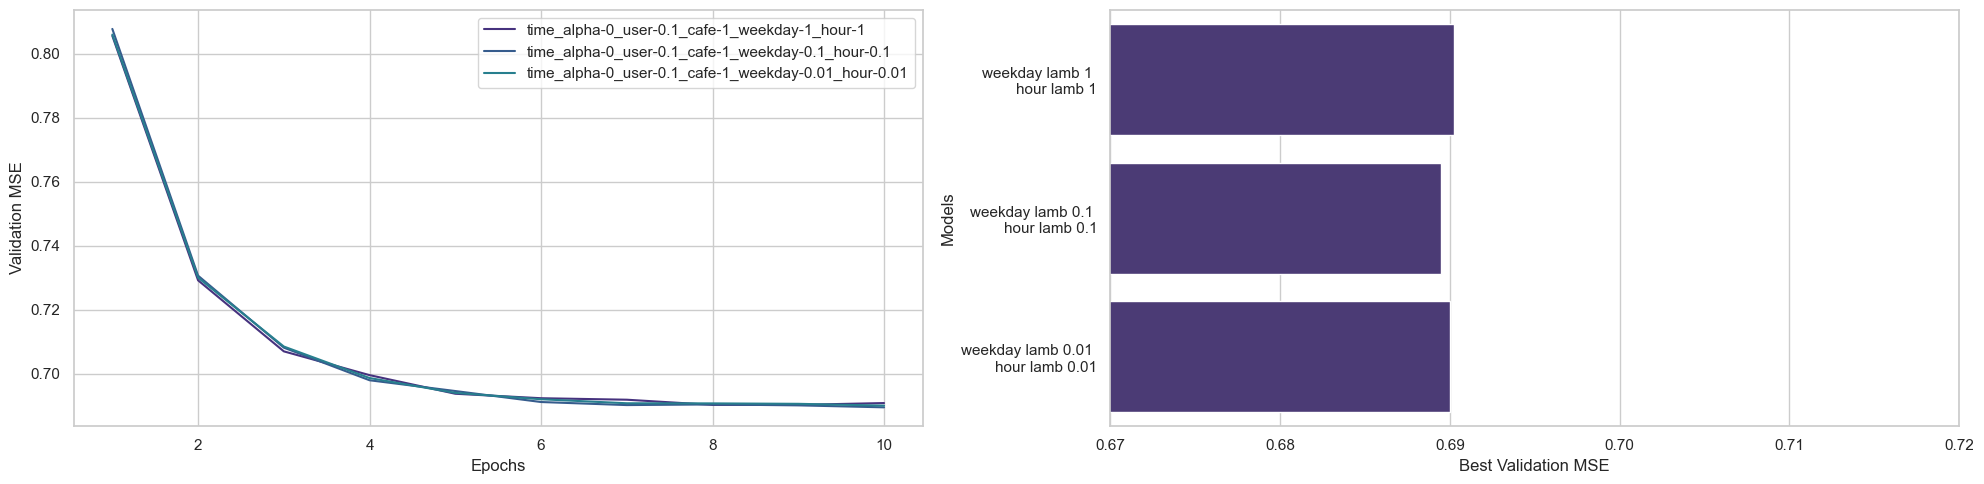

In [196]:
plot_results(params)

In [197]:
best_params["time"] = params[1]

### Review Time with Latents (User x Time)

In [198]:
params = [
    {
        "feat": "time_latent",
        "feat_names": ["alpha", "user", "cafe", "weekday", "hour"],
        "latent_names": ["user", "cafe", "weekday", "hour"],
        "latent_pairs": [["user", "cafe"], ["user", "weekday"], ["user", "hour"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "weekday": 1, "hour": 1},
        "test": 0
    },
    {
        "feat": "time_latent",
        "feat_names": ["alpha", "user", "cafe", "weekday", "hour"],
        "latent_names": ["user", "cafe", "weekday", "hour"],
        "latent_pairs": [["user", "cafe"], ["user", "weekday"], ["user", "hour"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "weekday": 0.1, "hour": 0.1},
        "test": 0
    },
    {
        "feat": "time_latent",
        "feat_names": ["alpha", "user", "cafe", "weekday", "hour"],
        "latent_names": ["user", "cafe", "weekday", "hour"],
        "latent_pairs": [["user", "cafe"], ["user", "weekday"], ["user", "hour"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "weekday": 0.01, "hour": 0.01},
        "test": 0
    }
]

In [199]:
if validation:
    for param_dict in params:
        train(param_dict)

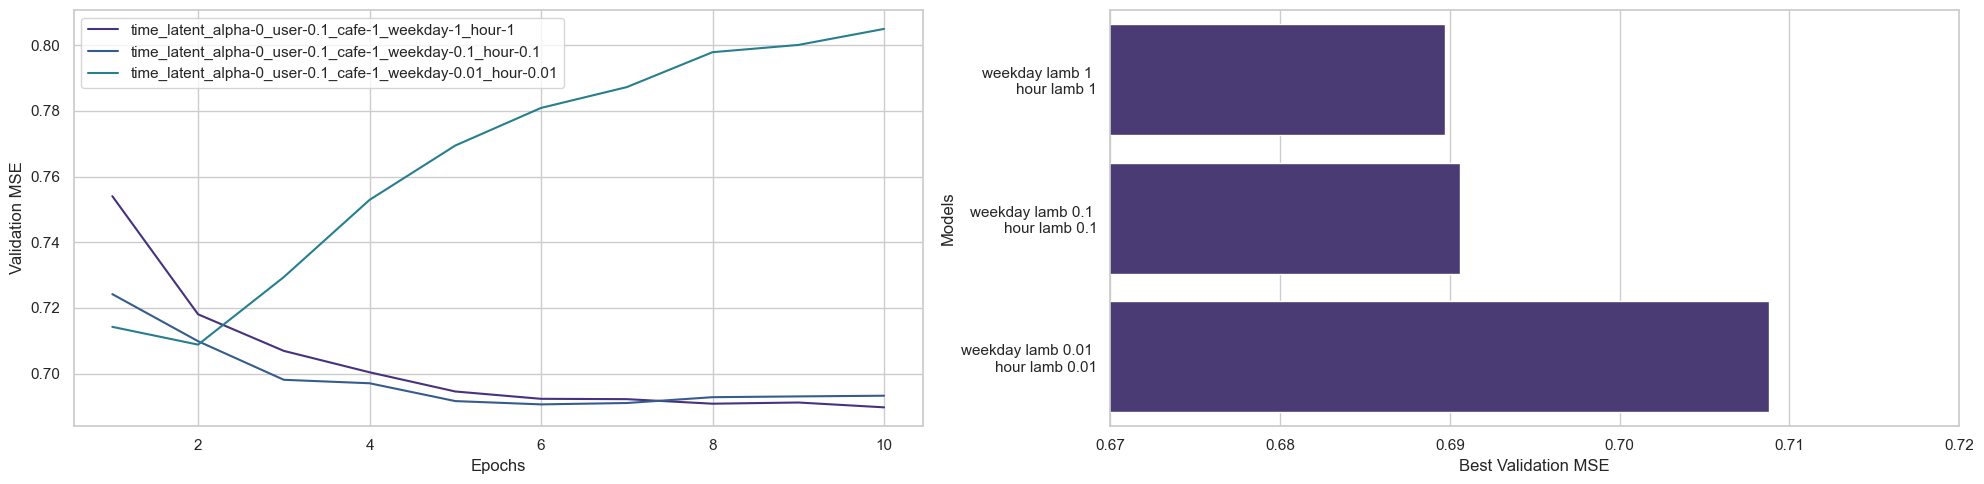

In [200]:
plot_results(params)

In [201]:
best_params["time_latent"] = params[0]

### Review Time with Latents (User x Time and Cafe x Time)

In [202]:
params = [
    {
        "feat": "time_all_latent",
        "feat_names": ["alpha", "user", "cafe", "weekday", "hour"],
        "latent_names": ["user", "cafe", "weekday", "hour"],
        "latent_pairs": [["user", "cafe"], ["user", "weekday"], ["user", "hour"], ["cafe", "weekday"], ["cafe", "hour"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "weekday": 1, "hour": 1},
        "test": 0
    },
    {
        "feat": "time_all_latent",
        "feat_names": ["alpha", "user", "cafe", "weekday", "hour"],
        "latent_names": ["user", "cafe", "weekday", "hour"],
        "latent_pairs": [["user", "cafe"], ["user", "weekday"], ["user", "hour"], ["cafe", "weekday"], ["cafe", "hour"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "weekday": 0.1, "hour": 0.1},
        "test": 0
    },
    {
        "feat": "time_all_latent",
        "feat_names": ["alpha", "user", "cafe", "weekday", "hour"],
        "latent_names": ["user", "cafe", "weekday", "hour"],
        "latent_pairs": [["user", "cafe"], ["user", "weekday"], ["user", "hour"], ["cafe", "weekday"], ["cafe", "hour"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "weekday": 0.01, "hour": 0.01},
        "test": 0
    }
]

In [203]:
if validation:
    for param_dict in params:
        train(param_dict)

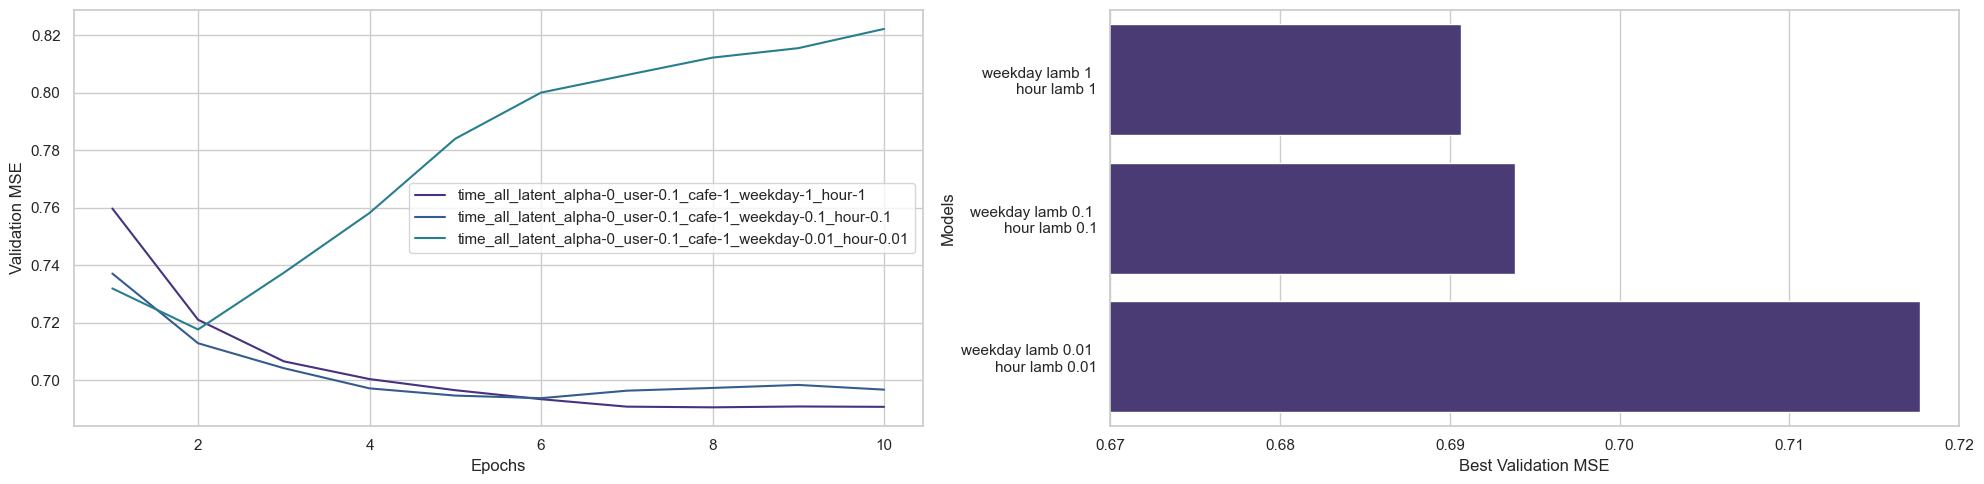

In [204]:
plot_results(params)

In [205]:
best_params["time_all_latent"] = params[0]

### Review Period without Latents

In [206]:
params = [
    {
        "feat": "period",
        "feat_names": ["alpha", "user", "cafe", "period"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "period": 0.01},
        "test": 0
    },
    {
        "feat": "period",
        "feat_names": ["alpha", "user", "cafe", "period"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "period": 0.1},
        "test": 0
    },
    {
        "feat": "period",
        "feat_names": ["alpha", "user", "cafe", "period"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "period": 1},
        "test": 0
    }
]

In [207]:
if validation:
    for param_dict in params:
        train(param_dict)

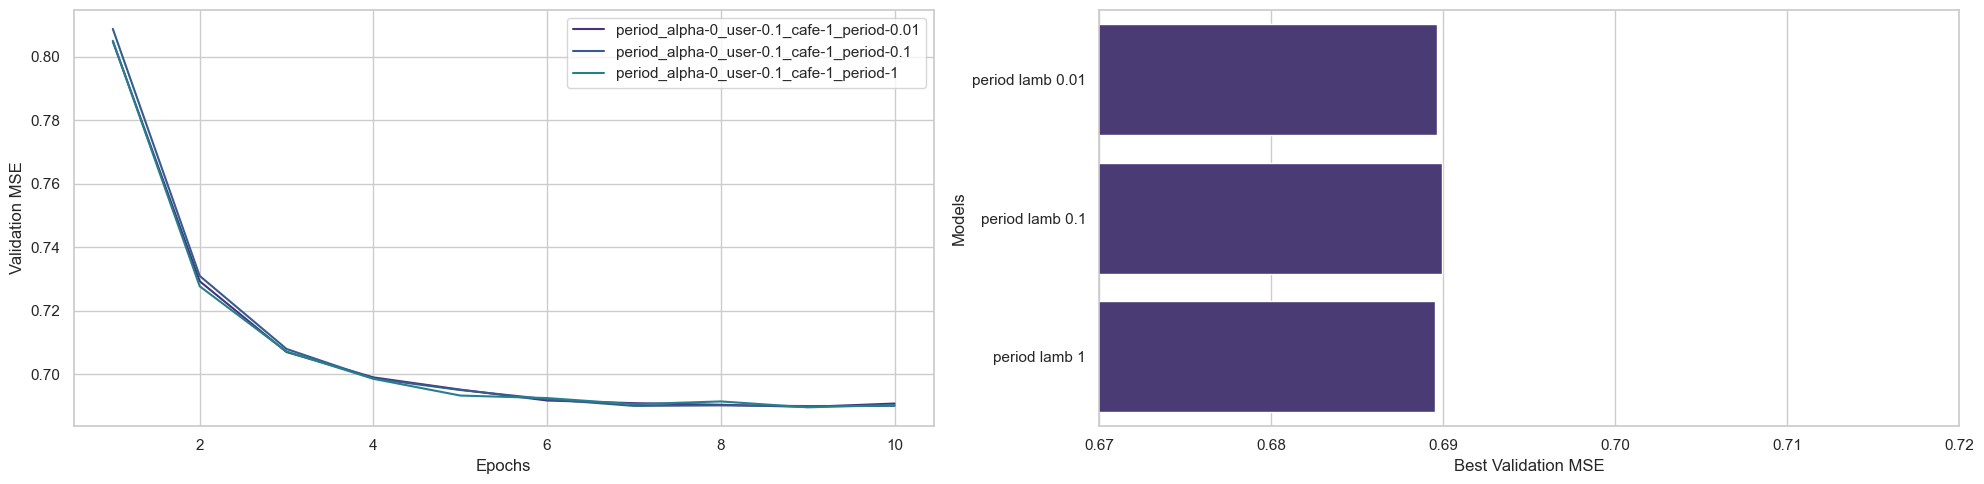

In [208]:
plot_results(params)

In [209]:
best_params["period"] = params[2]

### Review Period with Latents (User x Period)

In [210]:
params = [
    {
        "feat": "period_latent",
        "feat_names": ["alpha", "user", "cafe", "period"],
        "latent_names": ["user", "cafe", "period"],
        "latent_pairs": [["user", "cafe"], ["user", "period"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "period": 0.01},
        "test": 0
    },
    {
        "feat": "period_latent",
        "feat_names": ["alpha", "user", "cafe", "period"],
        "latent_names": ["user", "cafe", "period"],
        "latent_pairs": [["user", "cafe"], ["user", "period"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "period": 0.1},
        "test": 0
    },
    {
        "feat": "period_latent",
        "feat_names": ["alpha", "user", "cafe", "period"],
        "latent_names": ["user", "cafe", "period"],
        "latent_pairs": [["user", "cafe"], ["user", "period"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "period": 1},
        "test": 0
    }
]

In [211]:
if validation:
    for param_dict in params:
        train(param_dict)

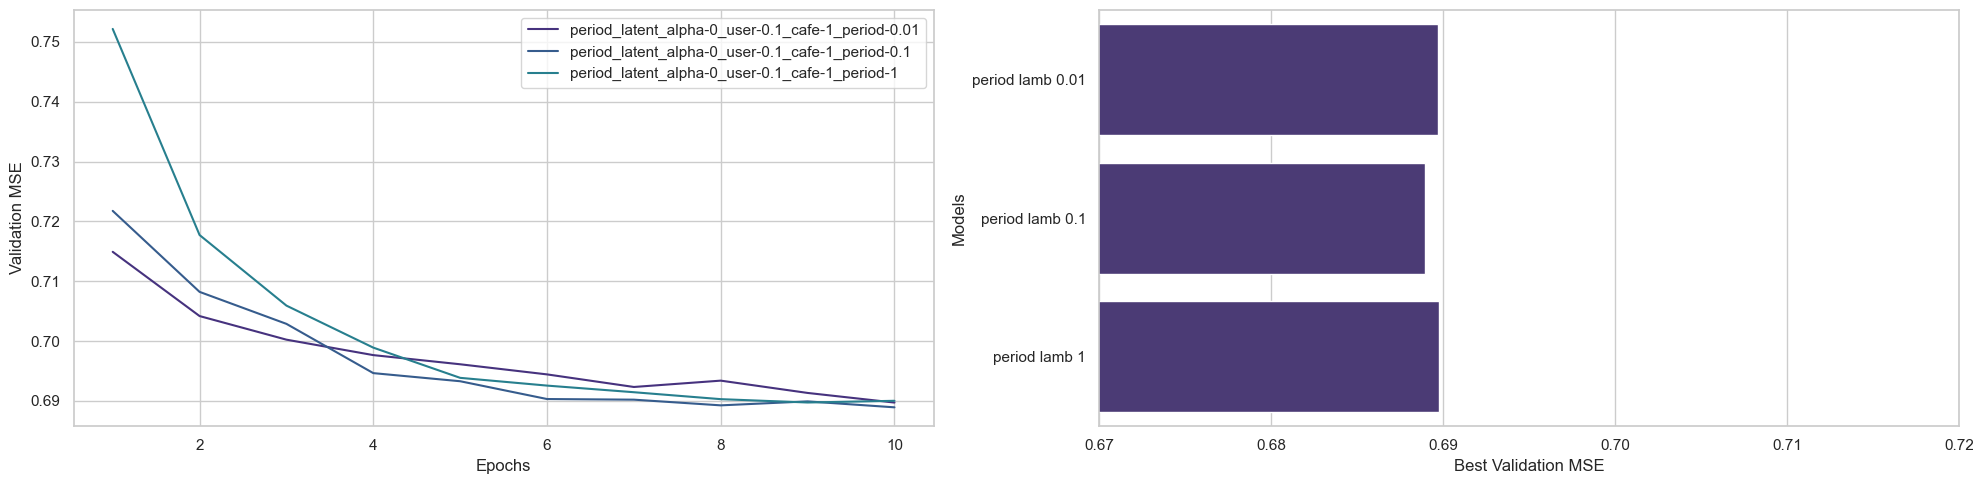

In [212]:
plot_results(params)

In [213]:
best_params["period_latent"] = params[1]

### Review Period with Latents (User x Period and Cafe x Period)

In [214]:
params = [
    {
        "feat": "period_all_latent",
        "feat_names": ["alpha", "user", "cafe", "period"],
        "latent_names": ["user", "cafe", "period"],
        "latent_pairs": [["user", "cafe"], ["user", "period"], ["cafe", "period"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "period": 0.01},
        "test": 0
    },
    {
        "feat": "period_all_latent",
        "feat_names": ["alpha", "user", "cafe", "period"],
        "latent_names": ["user", "cafe", "period"],
        "latent_pairs": [["user", "cafe"], ["user", "period"], ["cafe", "period"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "period": 0.1},
        "test": 0
    },
    {
        "feat": "period_all_latent",
        "feat_names": ["alpha", "user", "cafe", "period"],
        "latent_names": ["user", "cafe", "period"],
        "latent_pairs": [["user", "cafe"], ["user", "period"], ["cafe", "period"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "period": 1},
        "test": 0
    }
]

In [215]:
if validation:
    for param_dict in params:
        train(param_dict)

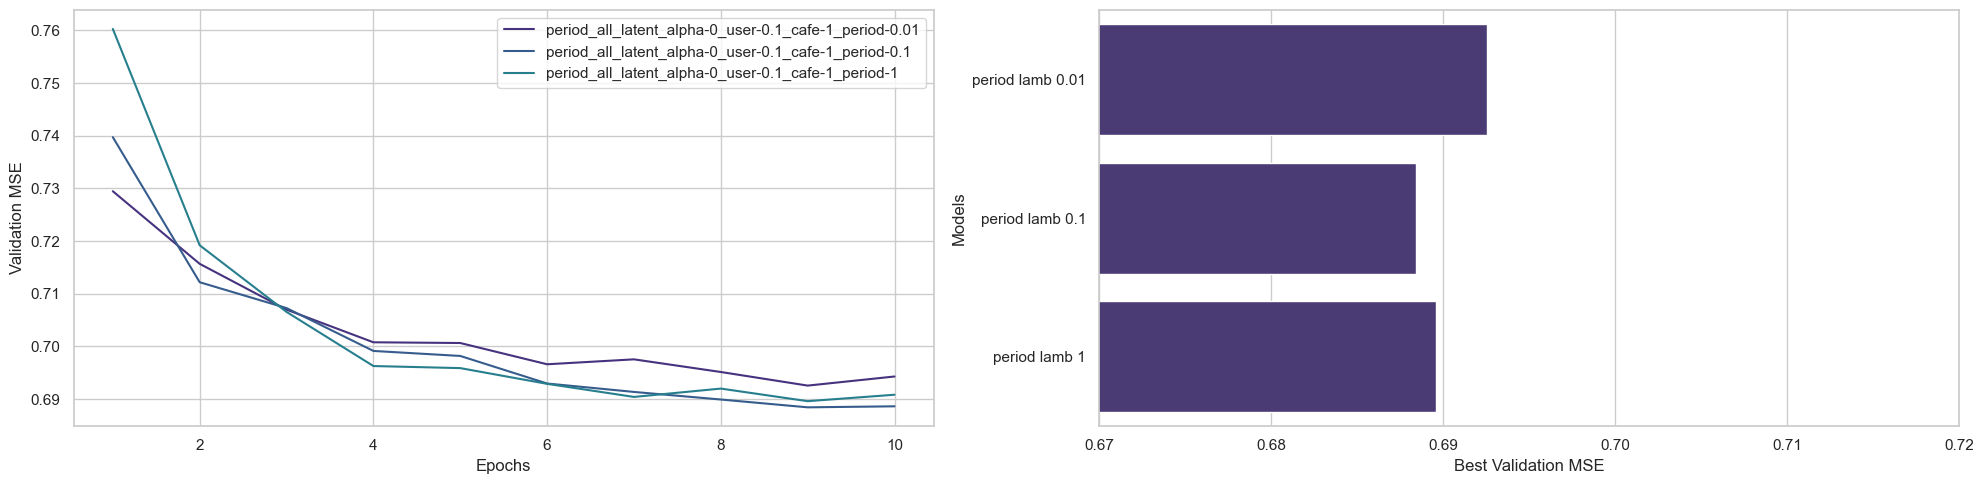

In [216]:
plot_results(params)

In [217]:
best_params["period_all_latent"] = params[1]

### Chains without Latents

In [218]:
params = [
    {
        "feat": "chains",
        "feat_names": ["alpha", "user", "cafe", "chains"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "chains": 0.01},
        "test": 0
    },
    {
        "feat": "chains",
        "feat_names": ["alpha", "user", "cafe", "chains"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "chains": 0.1},
        "test": 0
    },
    {
        "feat": "chains",
        "feat_names": ["alpha", "user", "cafe", "chains"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "chains": 1},
        "test": 0
    }
]

In [219]:
if validation:
    for param_dict in params:
        train(param_dict)

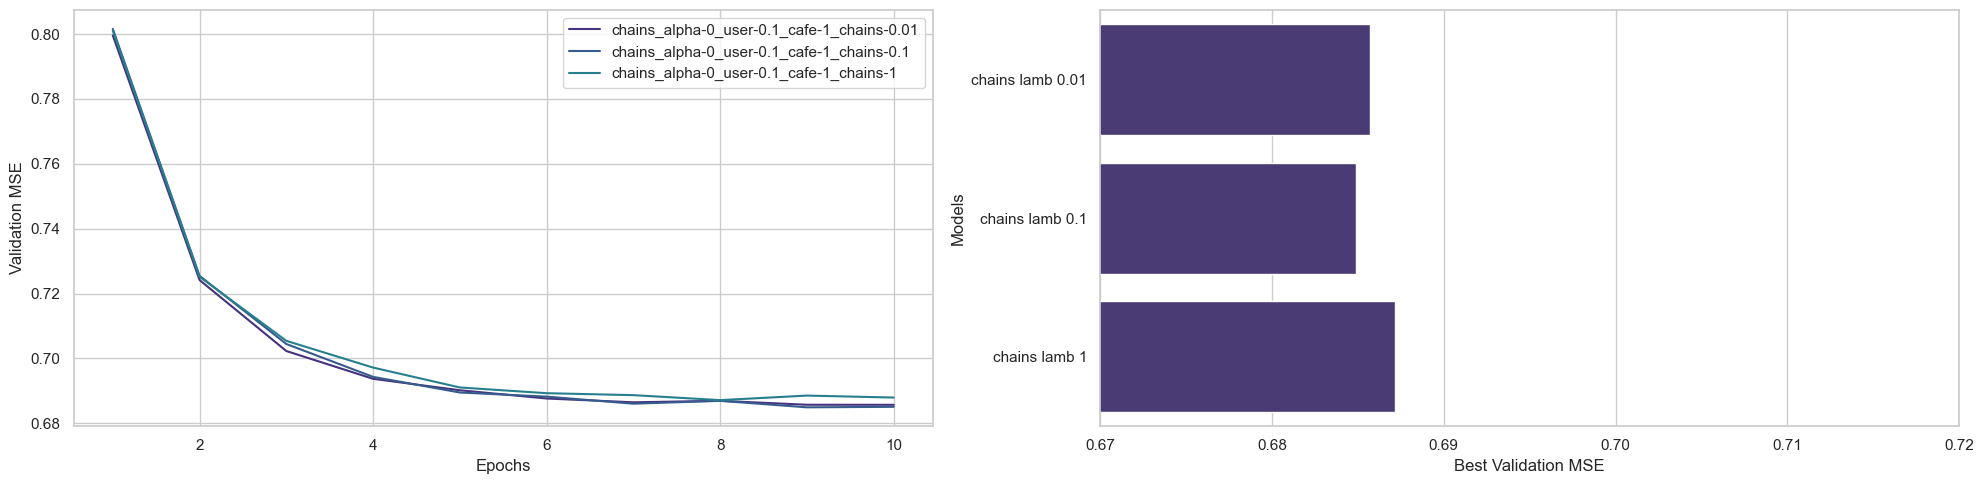

In [220]:
plot_results(params)

In [221]:
best_params["chains"] = params[1]

### Chains with Latents (User x Chain)

In [222]:
params = [
    {
        "feat": "chains_latent",
        "feat_names": ["alpha", "user", "cafe", "chains"],
        "latent_names": ["user", "cafe", "chains"],
        "latent_pairs": [["user", "cafe"], ["user", "chains"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "chains": 0.01},
        "test": 0
    },
    {
        "feat": "chains_latent",
        "feat_names": ["alpha", "user", "cafe", "chains"],
        "latent_names": ["user", "cafe", "chains"],
        "latent_pairs": [["user", "cafe"], ["user", "chains"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "chains": 0.1},
        "test": 0
    },
    {
        "feat": "chains_latent",
        "feat_names": ["alpha", "user", "cafe", "chains"],
        "latent_names": ["user", "cafe", "chains"],
        "latent_pairs": [["user", "cafe"], ["user", "chains"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "chains": 1},
        "test": 0
    }
]

In [223]:
if validation:
    for param_dict in params:
        train(param_dict)

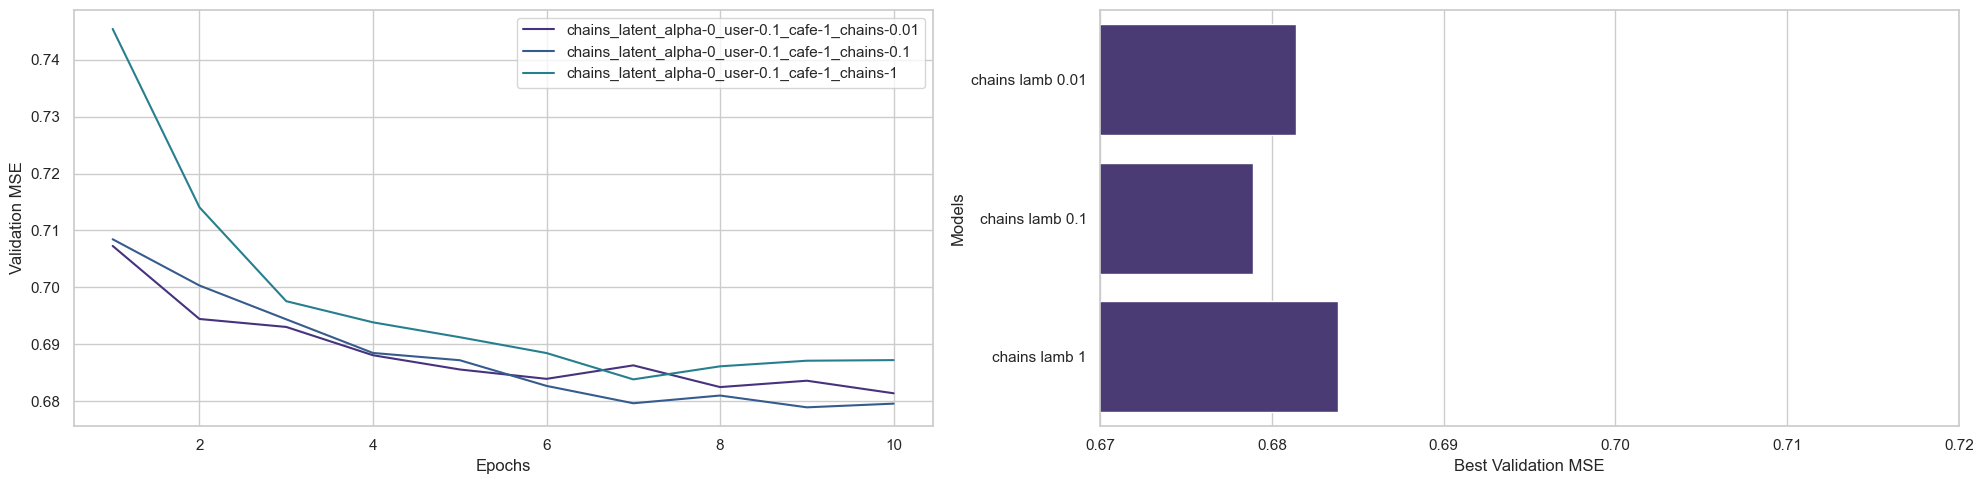

In [224]:
plot_results(params)

In [225]:
best_params["chains_latent"] = params[1]

### Price without Latents

In [226]:
params = [
    {
        "feat": "price",
        "feat_names": ["alpha", "user", "cafe", "price"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "price": 0.01},
        "test": 0
    },
    {
        "feat": "price",
        "feat_names": ["alpha", "user", "cafe", "price"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "price": 0.1},
        "test": 0
    },
    {
        "feat": "price",
        "feat_names": ["alpha", "user", "cafe", "price"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "price": 1},
        "test": 0
    }
]

In [227]:
if validation:
    for param_dict in params:
        train(param_dict)

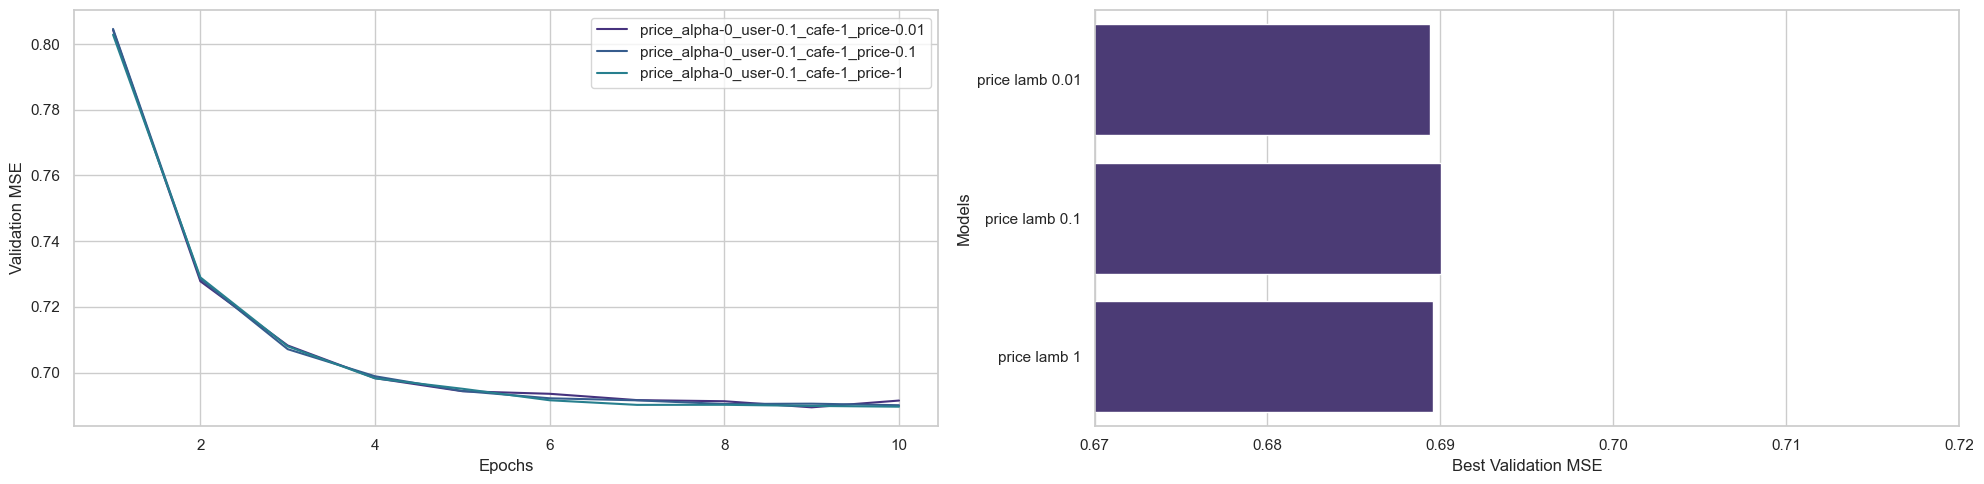

In [228]:
plot_results(params)

In [229]:
best_params["price"] = params[0]

### Price with Latents (User x Price)

In [230]:
params = [
    {
        "feat": "price_latent",
        "feat_names": ["alpha", "user", "cafe", "price"],
        "latent_names": ["user", "cafe", "price"],
        "latent_pairs": [["user", "cafe"], ["user", "price"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "price": 0.01},
        "test": 0
    },
    {
        "feat": "price_latent",
        "feat_names": ["alpha", "user", "cafe", "price"],
        "latent_names": ["user", "cafe", "price"],
        "latent_pairs": [["user", "cafe"], ["user", "price"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "price": 0.1},
        "test": 0
    },
    {
        "feat": "price_latent",
        "feat_names": ["alpha", "user", "cafe", "price"],
        "latent_names": ["user", "cafe", "price"],
        "latent_pairs": [["user", "cafe"], ["user", "price"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "price": 1},
        "test": 0
    }
]

In [231]:
if validation:
    for param_dict in params:
        train(param_dict)

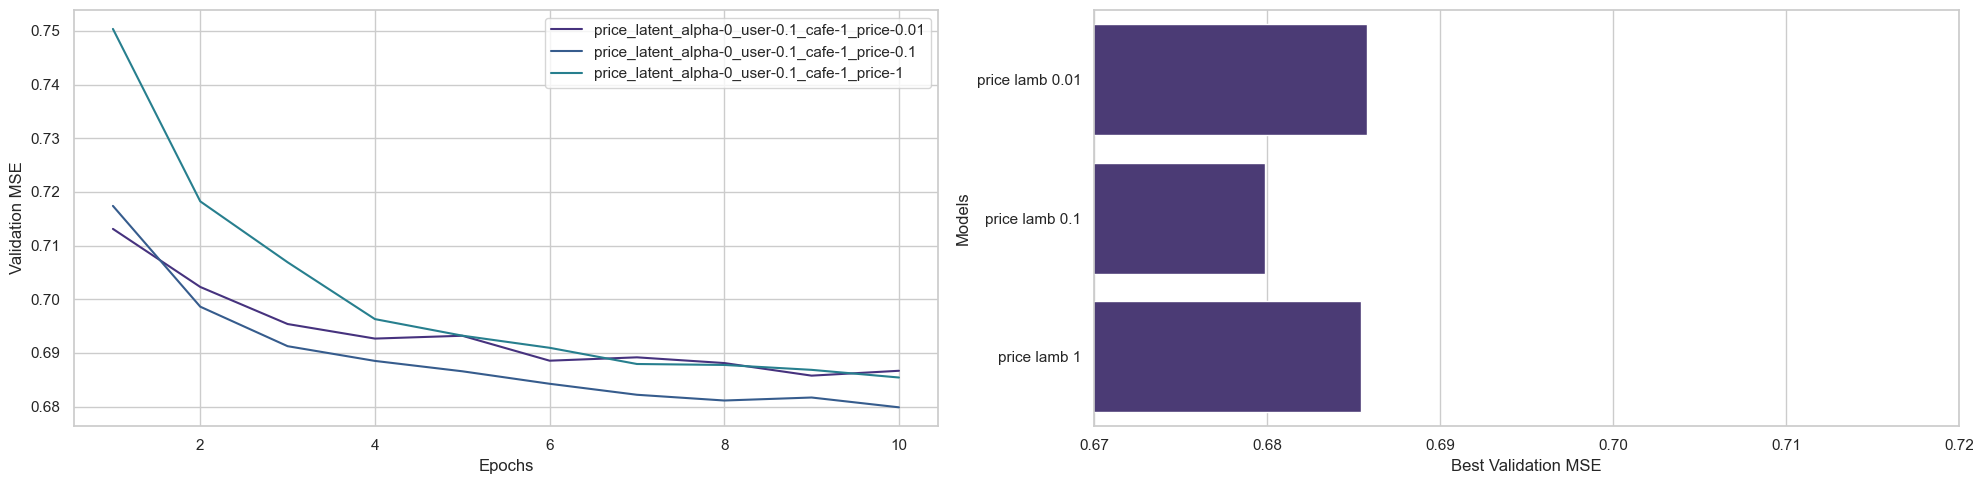

In [232]:
plot_results(params)

In [233]:
best_params["price_latent"] = params[1]

### Open Hours without Latents

In [234]:
params = [
    {
        "feat": "open_hours",
        "feat_names": ["alpha", "user", "cafe", "open_hours"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "open_hours": 0.01},
        "test": 0
    },
    {
        "feat": "open_hours",
        "feat_names": ["alpha", "user", "cafe", "open_hours"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "open_hours": 0.1},
        "test": 0
    },
    {
        "feat": "open_hours",
        "feat_names": ["alpha", "user", "cafe", "open_hours"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "open_hours": 1},
        "test": 0
    }
]

In [235]:
if validation:
    for param_dict in params:
        train(param_dict)

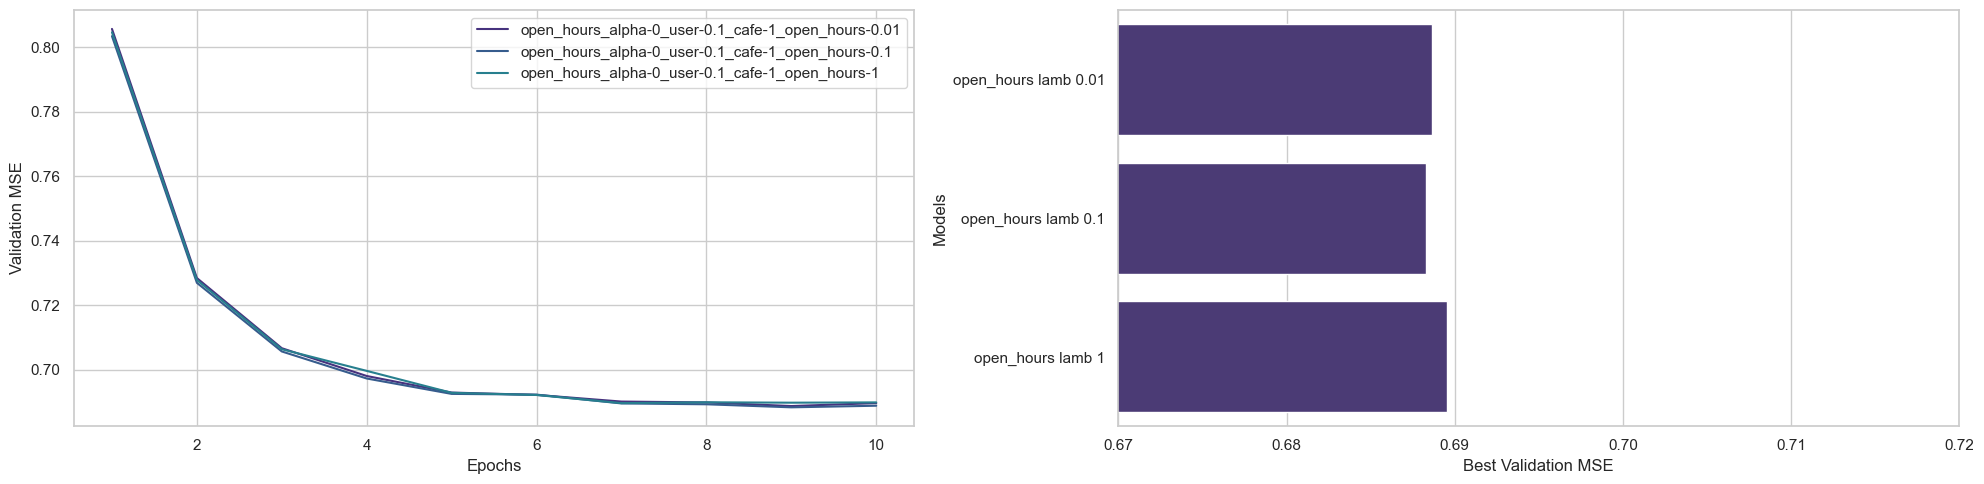

In [236]:
plot_results(params)

In [237]:
best_params["open_hours"] = params[1]

### Open Hours with Latents (User x Open Hours)

In [238]:
params = [
    {
        "feat": "open_hours_latent",
        "feat_names": ["alpha", "user", "cafe", "open_hours"],
        "latent_names": ["user", "cafe", "open_hours"],
        "latent_pairs": [["user", "cafe"], ["user", "open_hours"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "open_hours": 0.01},
        "test": 0
    },
    {
        "feat": "open_hours_latent",
        "feat_names": ["alpha", "user", "cafe", "open_hours"],
        "latent_names": ["user", "cafe", "open_hours"],
        "latent_pairs": [["user", "cafe"], ["user", "open_hours"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "open_hours": 0.1},
        "test": 0
    },
    {
        "feat": "open_hours_latent",
        "feat_names": ["alpha", "user", "cafe", "open_hours"],
        "latent_names": ["user", "cafe", "open_hours"],
        "latent_pairs": [["user", "cafe"], ["user", "open_hours"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "open_hours": 1},
        "test": 0
    }
]

In [239]:
if validation:
    for param_dict in params:
        train(param_dict)

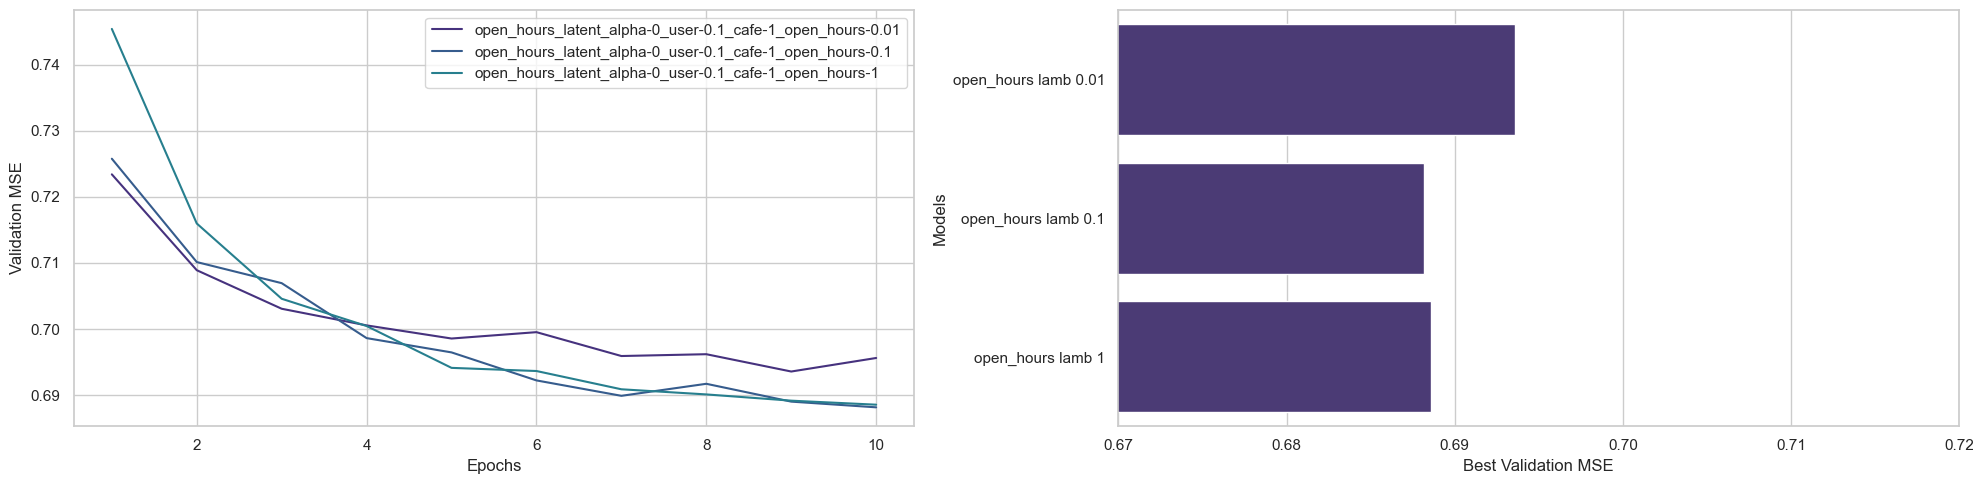

In [240]:
plot_results(params)

In [241]:
best_params["open_hours_latent"] = params[1]

### Location without Latents

In [242]:
params = [
    {
        "feat": "location",
        "feat_names": ["alpha", "user", "cafe", "location"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "location": 1},
        "test": 0
    },
    {
        "feat": "location",
        "feat_names": ["alpha", "user", "cafe", "location"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "location": 0.1},
        "test": 0
    },
    {
        "feat": "location",
        "feat_names": ["alpha", "user", "cafe", "location"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "location": 0.01},
        "test": 0
    }
]

In [243]:
if validation:
    for param_dict in params:
        train(param_dict)

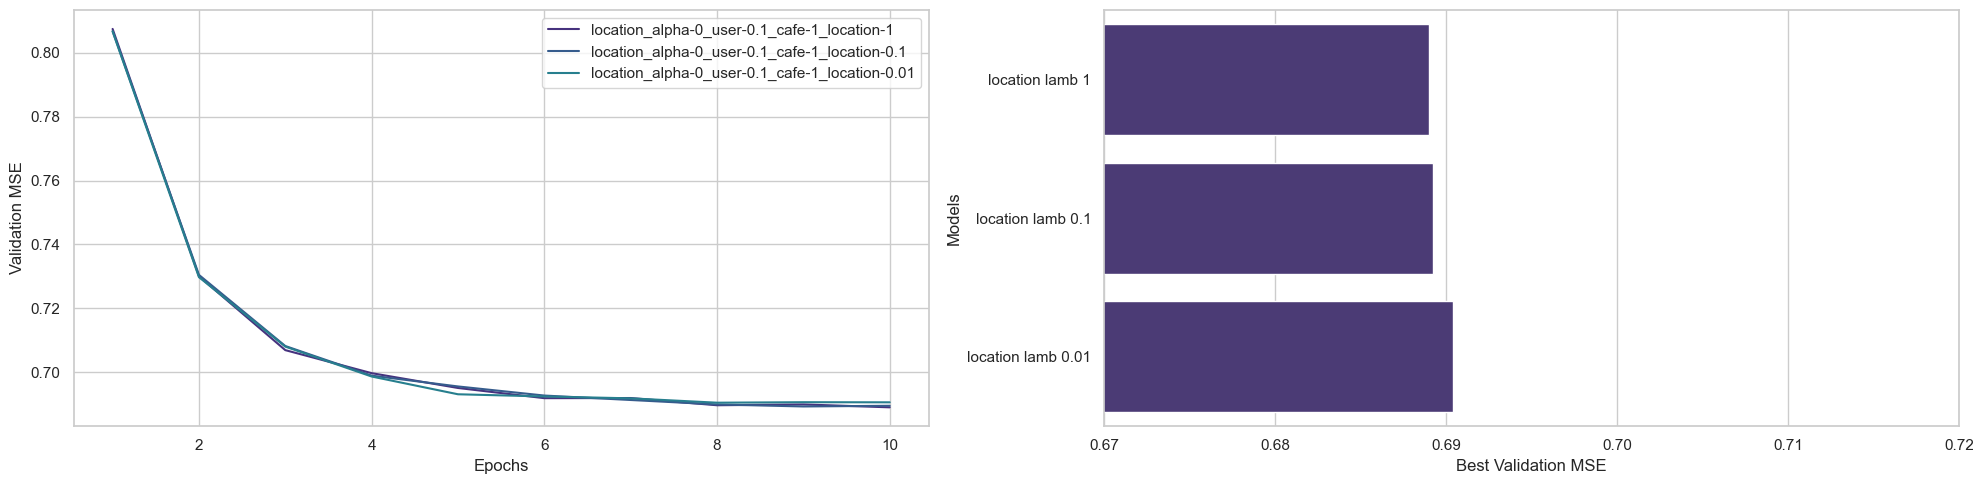

In [244]:
plot_results(params)

In [245]:
best_params["location"] = params[0]

### Location with Latents (User x Location)

In [246]:
params = [
    {
        "feat": "location_latent",
        "feat_names": ["alpha", "user", "cafe", "location"],
        "latent_names": ["user", "cafe", "location"],
        "latent_pairs": [["user", "cafe"], ["user", "location"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "location": 1},
        "test": 0
    },
    {
        "feat": "location_latent",
        "feat_names": ["alpha", "user", "cafe", "location"],
        "latent_names": ["user", "cafe", "location"],
        "latent_pairs": [["user", "cafe"], ["user", "location"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "location": 0.1},
        "test": 0
    },
    {
        "feat": "location_latent",
        "feat_names": ["alpha", "user", "cafe", "location"],
        "latent_names": ["user", "cafe", "location"],
        "latent_pairs": [["user", "cafe"], ["user", "location"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "location": 0.01},
        "test": 0
    }
]

In [247]:
if validation:
    for param_dict in params:
        train(param_dict)

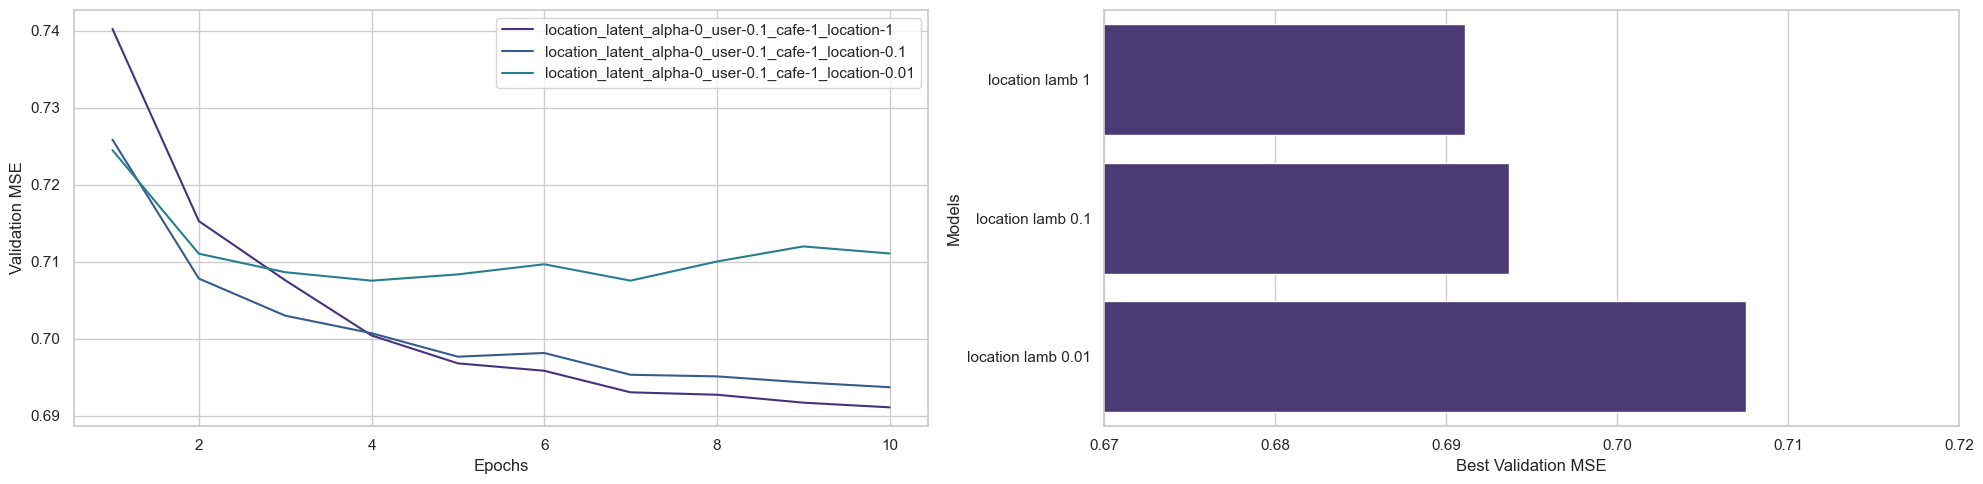

In [248]:
plot_results(params)

In [249]:
best_params["location_latent"] = params[0]

### Previous Cafe without Shared Latents (Cafe x Prev Cafe)

In [250]:
params = [
    {
        "feat": "prev_latent",
        "feat_names": ["alpha", "user", "cafe", "prev"],
        "latent_names": ["user", "cafe", "prev"],
        "latent_pairs": [["user", "cafe"], ["cafe", "prev"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "prev": 0.01},
        "test": 0
    },
    {
        "feat": "prev_latent",
        "feat_names": ["alpha", "user", "cafe", "prev"],
        "latent_names": ["user", "cafe", "prev"],
        "latent_pairs": [["user", "cafe"], ["cafe", "prev"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "prev": 0.1},
        "test": 0
    },
    {
        "feat": "prev_latent",
        "feat_names": ["alpha", "user", "cafe", "prev"],
        "latent_names": ["user", "cafe", "prev"],
        "latent_pairs": [["user", "cafe"], ["cafe", "prev"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "prev": 1},
        "test": 0
    },
    {
        "feat": "prev_latent",
        "feat_names": ["alpha", "user", "cafe", "prev"],
        "latent_names": ["user", "cafe", "prev"],
        "latent_pairs": [["user", "cafe"], ["cafe", "prev"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1, "prev": 2},
        "test": 0
    }
]

In [251]:
if validation:
    for param_dict in params:
        train(param_dict)

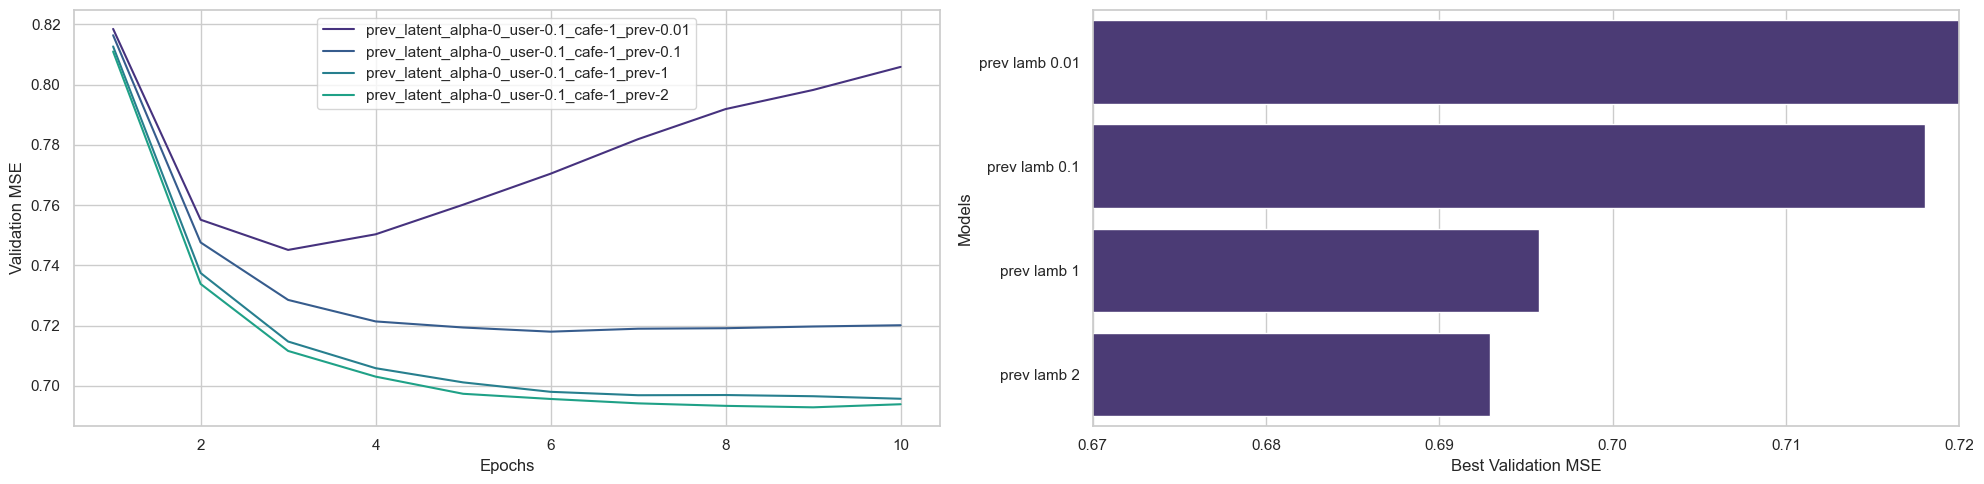

In [252]:
plot_results(params)

In [253]:
best_params["prev_latent"] = params[3]

### Previous Cafe with Shared Latents (Cafe x Prev Cafe)

In [254]:
params = [
    {
        "feat": "prev_share_latent",
        "feat_names": ["alpha", "user", "cafe", "prev"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"], ["cafe", "prev"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1},
        "share_latents": 1,
        "test": 0
    }
]

In [255]:
if validation:
    for param_dict in params:
        train(param_dict)

In [256]:
best_params["prev_share_latent"] = params[0]

### Comparisons

In [262]:
def plot_validation_comparisons(params):
    if not os.path.exists("./metrics.json"):
        return None

    with open("./metrics.json", "r") as f:
        metrics = json.load(f)

    categories, mses = [], []
    for category, param_dict in params.items():
        name = get_name(param_dict)
        mse = min(metrics[name]["metrics"]["valid"])

        categories.append(category)
        mses.append(mse)

    df = pd.DataFrame({"category": categories, "mse": mses})
    baseline = df[df["category"] == "base_latent"]["mse"].values[0]
    df["baseline"] = df["mse"].apply(lambda x: x < baseline)

    plt.figure(figsize=(30, 5))
    sns.set_theme(style="whitegrid", palette="viridis")
    sns.barplot(df, x="category", y="mse", hue="baseline")

    plt.ylim(0.66, 0.70)
    plt.xlabel("Models with different features")
    plt.ylabel("Validation MSE")
    plt.title("Comparison of validation MSE for models with different features")
    plt.axhline(baseline, linestyle="--")
    plt.show()


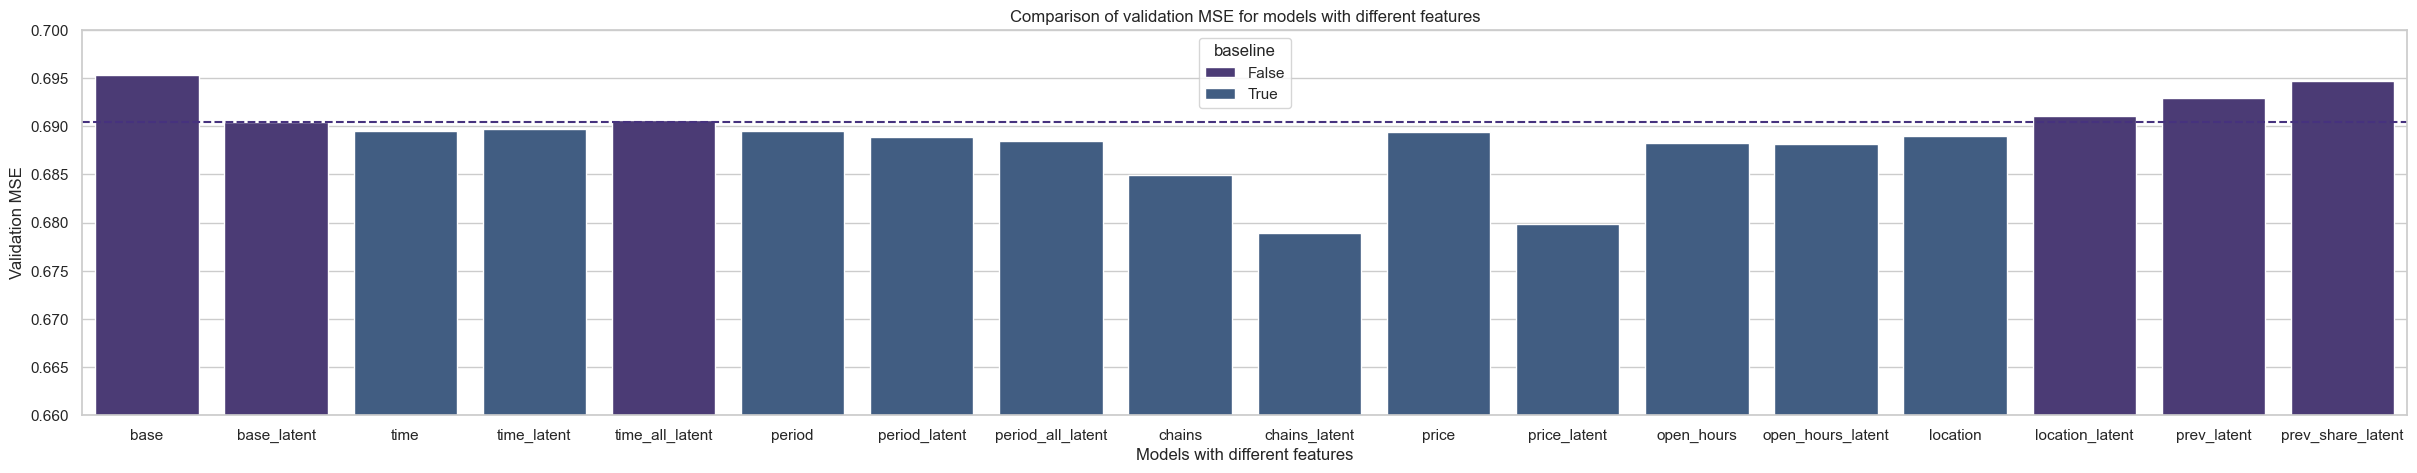

In [264]:
plot_validation_comparisons(best_params)

### Final Model
Based on validation results above, we ended up building a model as follows:

In [265]:
final_param_dict = {
    "feat": "final",
    "feat_names": [
        "alpha", "user", "cafe",
        "chains", "price", "open_hours", "location",
        "weekday", "hour", "period"
    ],
    "latent_names": ["user", "cafe", "chains", "price", "open_hours", "weekday", "hour", "period"],
    "latent_pairs": [
        ["user", "cafe"],
        ["user", "chains"],
        ["user", "price"],
        ["user", "open_hours"],
        ["user", "weekday"],
        ["user", "hour"],
        ["user", "period"],
        ["cafe", "period"]
    ],
    "lamb_dict": {
        "alpha": 0,
        "user": 0.1,
        "cafe": 1,
        "chains": 0.1,
        "price": 0.1,
        "open_hours": 0.1,
        "location": 1,
        "weekday": 1,
        "hour": 1,
        "period": 0.1
    },
    "test": 1
}

In [267]:
train(final_param_dict)

Start training final_alpha-0_user-0.1_cafe-1_chains-0.1_price-0.1_open_hours-0.1_location-1_weekday-1_hour-1_period-0.1


Training Model (0.744673): 100%|██████████| 106/106 [00:31<00:00,  3.40it/s]


Step[ 1]: train 0.773280 / valid 0.711506


Training Model (0.723013): 100%|██████████| 106/106 [00:31<00:00,  3.33it/s]


Step[ 2]: train 0.662653 / valid 0.693076


Training Model (0.648205): 100%|██████████| 106/106 [00:32<00:00,  3.28it/s]


Step[ 3]: train 0.634097 / valid 0.682231


Training Model (0.624585): 100%|██████████| 106/106 [00:32<00:00,  3.31it/s]


Step[ 4]: train 0.613547 / valid 0.677255


Training Model (0.540974): 100%|██████████| 106/106 [00:31<00:00,  3.40it/s]


Step[ 5]: train 0.599922 / valid 0.675377


Training Model (0.647390): 100%|██████████| 106/106 [00:31<00:00,  3.34it/s]


Step[ 6]: train 0.588789 / valid 0.677701


Training Model (0.579159): 100%|██████████| 106/106 [00:31<00:00,  3.39it/s]


Step[ 7]: train 0.581164 / valid 0.672210


Training Model (0.652499): 100%|██████████| 106/106 [00:31<00:00,  3.38it/s]


Step[ 8]: train 0.573041 / valid 0.670399


Training Model (0.598041): 100%|██████████| 106/106 [00:29<00:00,  3.61it/s]


Step[ 9]: train 0.565361 / valid 0.671455


Training Model (0.515577): 100%|██████████| 106/106 [00:32<00:00,  3.28it/s]


Step[10]: train 0.559420 / valid 0.669061


### Baselines
We need two baselines for further analysis and testing.

In [268]:
baseline_params = [
    {
        "feat": "base",
        "feat_names": ["alpha", "user", "cafe"],
        "latent_names": [],
        "latent_pairs": [],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1},
        "test": 1
    },
    {
        "feat": "base_latent",
        "feat_names": ["alpha", "user", "cafe"],
        "latent_names": ["user", "cafe"],
        "latent_pairs": [["user", "cafe"]],
        "lamb_dict": {"alpha": 0, "user": 0.1, "cafe": 1},
        "test": 1
    }
]

In [269]:
for baseline_param_dict in baseline_params:
    train(baseline_param_dict)

### Testing Models

We used three ways to evaluate models as follows:
- `mse` is a metric used as an objective for training.
- `rmse` is a root of mse which has same scale as predictive variable (rating).
- `accuracy` is accuracy of correct discrete rating prediction. Since all reviews have discrete ratings of 1.0, 2.0, 3.0, 4.0 and 5.0, given predictions, we asigned discrete prediction by rounding to nearest integer and calculated accuracy comparing true ratings.

In [295]:
def calculate_mse(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)

def calculate_rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

def discrete_rating(y_pred):
    y_pred = torch.clamp(y_pred, min=0, max=5)
    y_pred = torch.round(y_pred)

    return y_pred

For testing, we saved results in csv table so that we can compare models easily, which is saved to `./test_results.csv`.

In [296]:
def update_test_results(result):
    new_result = pd.Series(result).to_frame().T

    if os.path.exists("./test_results.csv"):
        results = pd.read_csv("./test_results.csv")

        duplicate_index = results["name"] == result["name"]
        if sum(duplicate_index) == 0:
            results = pd.concat([results, new_result]).reset_index(drop=True)
        else:
            results = results.values
            results[duplicate_index] = new_result.values
            results = pd.DataFrame(results, columns=new_result.columns)
    else:
        results = new_result

    print(results)
    results.to_csv("./test_results.csv", index=False)

In [297]:
def evaluate_model(name, test_dataloader, model, device):
    with torch.no_grad():
        total = 0
        mse, rmse = 0, 0
        n_corrects = 0

        model.to(device)
        model.eval()

        feat_names = model.feat_names

        for feats in test_dataloader:
            ratings = feats[-1].to(device)
            feats = {name: f.to(device) for name, f in zip(feat_names, feats[:-1])}

            pred_ratings = model(feats)

            batch_size = feats["alpha"].size(0)
            mse += calculate_mse(ratings, pred_ratings).item() * batch_size
            rmse += calculate_rmse(ratings, pred_ratings).item() * batch_size

            pred_discrete = discrete_rating(pred_ratings)

            n_corrects += torch.sum(pred_discrete == ratings).item()
            total += batch_size

        test_mse = mse / total
        test_rmse = rmse / total
        test_accuracy = n_corrects / total

        return {"name": name, "mse": test_mse, "rmse": test_rmse, "accuracy": test_accuracy}

First we evaluate two baseline models:
- `MostCommon` just returns most common discrete rating `5`.
- `Naive` just returns a global average.

In [298]:
class MostCommon(nn.Module):
    def __init__(self):
        super().__init__()

        reviews = pd.read_csv("./datasets/splits/test.csv")

        ratings, counts = np.unique(reviews["rating"], return_counts=True)
        self.most_common = torch.tensor(ratings[np.argmax(counts)])

        self.feat_names = ["alpha"]

    def forward(self, x):
        return self.most_common.repeat(x["alpha"].size(0))

class Naive(nn.Module):
    def __init__(self):
        super().__init__()

        reviews = pd.read_csv("./datasets/splits/test.csv")
        self.average = torch.tensor(np.mean(reviews["rating"]))

        self.feat_names = ["alpha"]

    def forward(self, x):
        return self.average.repeat(x["alpha"].size(0))

The following a function to run models on test dataset and save results into `test_results.csv`.

In [299]:
def test_model(param_dict, name=None):
    if name == "most_common":
        model = MostCommon()
        feat_names = ["alpha"]
    elif name == "naive":
        model = Naive()
        feat_names = ["alpha"]
    else:
        feat = param_dict["feat"]
        feat_names = param_dict["feat_names"]
        lamb_dict = param_dict["lamb_dict"]

        test = param_dict["test"]

        lamb_str = "_".join([f"{name}-{value}" for name, value in lamb_dict.items()])
        name = f"{feat}_{lamb_str}"

        if not test:
            return

        model_path = f"./models/{name}.pt"

        if not os.path.exists(model_path):
            return

        print(f"Loading model from {model_path}")
        model = torch.load(model_path, weights_only=False)

    feat_dicts, _ = preprocess_data_latent(feat_names)
    test_dataset = CafeDatasetLatent("test", feat_names, feat_dicts)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    result = evaluate_model(name, test_dataloader, model, device)

    update_test_results(result)


Run MostCommon and Naive first.

In [300]:
name = "most_common"
test_model(None, name)

          name       mse      rmse  accuracy
0  most_common  1.594156  1.262462  0.523571


In [301]:
test_name = "naive"
test_model(None, test_name)

          name       mse      rmse  accuracy
0  most_common  1.594156  1.262462  0.523571
1        naive  1.006339  1.002985   0.28008


In [302]:
for baseline_param_dict in baseline_params:
    test_model(baseline_param_dict)

Loading model from ./models/base_alpha-0_user-0.1_cafe-1.pt
                           name       mse      rmse  accuracy
0                   most_common  1.594156  1.262462  0.523571
1                         naive  1.006339  1.002985   0.28008
2  base_alpha-0_user-0.1_cafe-1  0.687114  0.828668  0.556383
Loading model from ./models/base_latent_alpha-0_user-0.1_cafe-1.pt
                                  name       mse      rmse  accuracy
0                          most_common  1.594156  1.262462  0.523571
1                                naive  1.006339  1.002985   0.28008
2         base_alpha-0_user-0.1_cafe-1  0.687114  0.828668  0.556383
3  base_latent_alpha-0_user-0.1_cafe-1  0.681222  0.825174  0.559864


In [303]:
test_model(final_param_dict)

Loading model from ./models/final_alpha-0_user-0.1_cafe-1_chains-0.1_price-0.1_open_hours-0.1_location-1_weekday-1_hour-1_period-0.1.pt
                                                name       mse      rmse  \
0                                        most_common  1.594156  1.262462   
1                                              naive  1.006339  1.002985   
2                       base_alpha-0_user-0.1_cafe-1  0.687114  0.828668   
3                base_latent_alpha-0_user-0.1_cafe-1  0.681222  0.825174   
4  final_alpha-0_user-0.1_cafe-1_chains-0.1_price...  0.657577  0.810797   

   accuracy  
0  0.523571  
1   0.28008  
2  0.556383  
3  0.559864  
4  0.574121  


### Final Comparision

In [312]:
def plot_test_comparisons():
    if not os.path.exists("./metrics.json"):
        return None

    df = pd.read_csv("test_results.csv")

    names = []
    for name in df["name"].values:
        print(name)
        if "final" in name:
            names.append("final")
        elif "base_latent" in name:
            names.append("base_latent")
        elif "base" in name:
            names.append("base")
        else:
            names.append(name)
    df["name"] = names

    eval_list = list(df.columns)[1:]
    print(eval_list)

    _, axes = plt.subplots(nrows=1, ncols=len(eval_list), figsize=(30, 5))
    sns.set_theme(style="whitegrid", palette="viridis")

    for i in range(len(eval_list)):
        sns.barplot(df, x="name", y=eval_list[i], ax=axes[i])
        axes[i].set_title(eval_list[i])

    plt.suptitle("Comparison of test performances of final model and baselines")
    plt.show()


most_common
naive
base_alpha-0_user-0.1_cafe-1
base_latent_alpha-0_user-0.1_cafe-1
final_alpha-0_user-0.1_cafe-1_chains-0.1_price-0.1_open_hours-0.1_location-1_weekday-1_hour-1_period-0.1
['mse', 'rmse', 'accuracy']


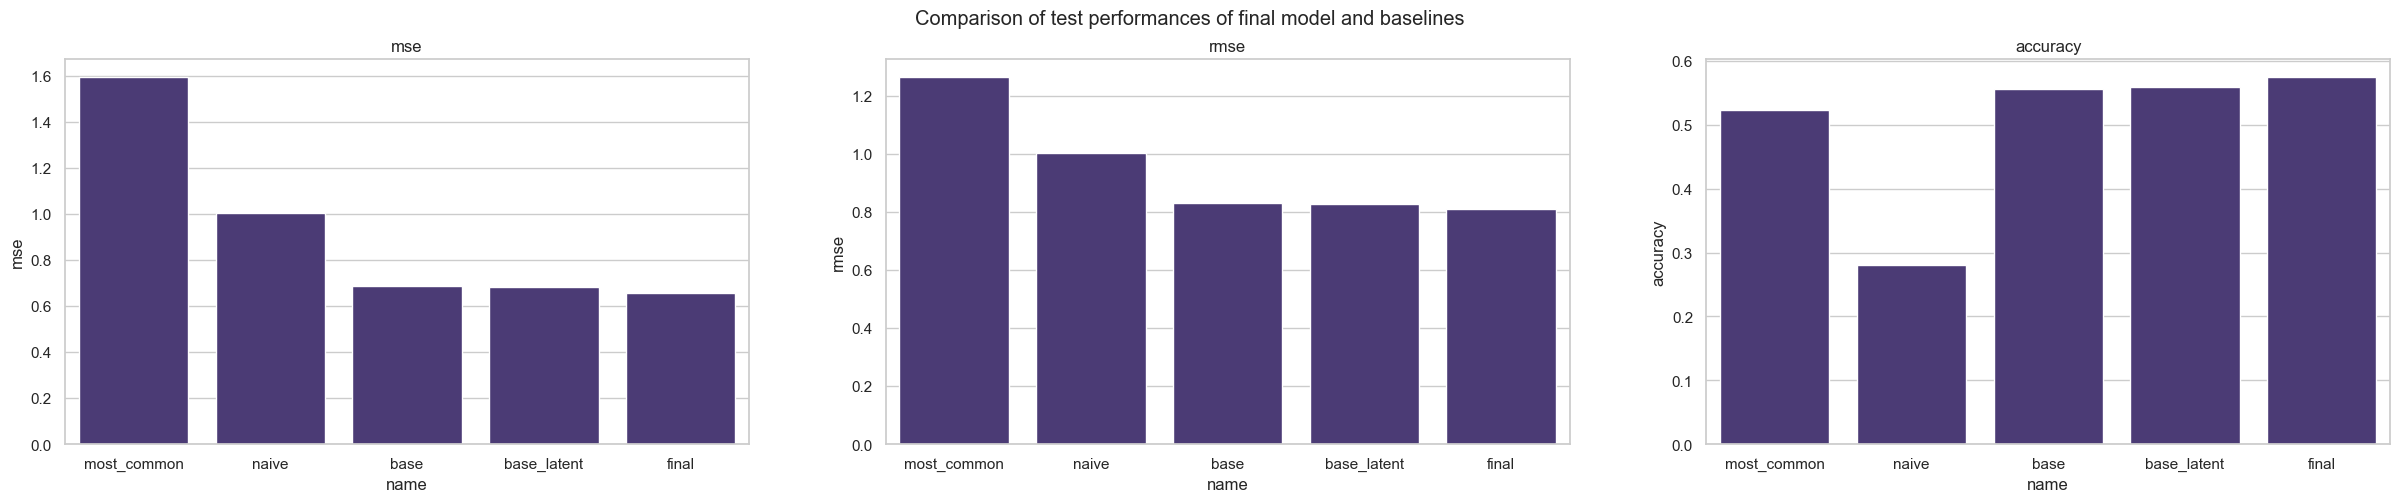

In [313]:
plot_test_comparisons()

In [ ]:
def load_table_data():
    cafes = pd.read_csv("../datasets/processed/cafes.csv")
    users = pd.read_csv("../datasets/processed/users.csv")
    reviews = pd.read_csv("../datasets/processed/reviews.csv")

    return cafes, users, reviews

def create_user_review_dicts(reviews):
    ratings = []
    user2cafes = defaultdict(list)
    cafe2users = defaultdict(list)

    for (user, cafe, rating) in reviews[["user_id", "gmap_id", "rating"]].values:
        ratings.append((user, cafe, rating))
        user2cafes[user].append((cafe, rating))
        cafe2users[cafe].append((user, rating))


    return ratings, user2cafes, cafe2users

In [ ]:
# Import data into notebook
cafes, users, reviews = load_table_data()
ratings, user2cafes, cafes2users = create_user_review_dicts(reviews)

In [ ]:
# Basics:

# Get number of users
print("Number of Users: ", len(users))
# Get number of cafes
print("Number of Cafes: ", len(cafes))
# Get number of reviews
print("Number of Reviews: ", len(reviews))

# Format of Cafe Data
print("CAFE EXAMPLE DATA: \n", cafes.head(), "\n")

In [ ]:
# Data Visualization:

# Formatting from price using '$' symbol

def price_to_num(p):
    if pd.isna(p):
        return np.nan
    p = str(p).strip()
    if p == "" or p.lower() == "none":
        return np.nan
    n = p.count("$")
    return n if n > 0 else np.nan

cafes["price_num"] = cafes["price"].apply(price_to_num)
cafes["price_num"].value_counts(dropna=False)


# Parsing hours if the cafe has them

def parse_time_token(tok):
    tok = tok.strip().upper() # cleaning text to parse

    # Checking 24h like 18:00
    m24 = re.match(r"^(\d{1,2}):(\d{2})$", tok) # trying to match 24-hour format
    if m24:
        hour, minute = int(m24.group(1)), int(m24.group(2))
        return hour*60 + minute

    # Checking AM/PM like 7AM, 7:30 PM
    m = re.match(r"^(\d{1,2})(?::(\d{2}))?\s*(AM|PM)$", tok)
    if not m:
        return None
    hour = int(m.group(1))
    minute = int(m.group(2)) if m.group(2) else 0
    ampm = m.group(3)
    if ampm == "PM" and hour != 12: hour += 12
    if ampm == "AM" and hour == 12: hour = 0
    return hour*60 + minute

# Converting intervals of hours to a consistent number
def interval_to_hours(interval_str):
    s = str(interval_str).replace("–", "-").replace("—", "-").strip()
    if s.lower() in ["closed", "none", "nan", ""]:
        return 0.0
    if "24 hours" in s.lower():
        return 24.0

    parts = [p.strip() for p in s.split("-")]
    if len(parts) != 2:
        return np.nan

    start = parse_time_token(parts[0])
    end = parse_time_token(parts[1])
    if start is None or end is None:
        return np.nan

    if end < start:  # Overnight
        end += 24*60
    return (end - start) / 60.0

# Summing weeks hours
def hours_to_weekly_total(hours_field):
    if pd.isna(hours_field): # returning nan if no hours exist for cafe
        return np.nan
    try:
        data = ast.literal_eval(hours_field) if isinstance(hours_field, str) else hours_field
    except Exception:
        return np.nan
    if not isinstance(data, (list, tuple)):
        return np.nan

    total = 0.0
    for item in data:
        if not item or len(item) < 2:
            continue
        intervals = item[1]
        if isinstance(intervals, str):
            total += interval_to_hours(intervals)
        elif isinstance(intervals, (list, tuple)): # if the cafe has multiple intervals of open times
            for inter in intervals:
                total += interval_to_hours(inter)
    return total

cafes["weekly_hours"] = cafes["hours"].apply(hours_to_weekly_total)
cafes["avg_daily_hours"] = cafes["weekly_hours"] / 7.0

cafes[["hours","weekly_hours","avg_daily_hours"]].head(3)


# Combining cafes and reviews

df = reviews.merge(
    cafes[["gmap_id","name","latitude","longitude","price_num","avg_daily_hours","avg_rating"]],
    on="gmap_id",
    how="left"
)
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
df.head()



# Hours vs Rating - data prep

cafe_avg = df.groupby("gmap_id").agg(
    avg_user_rating=("rating","mean"),
    avg_daily_hours=("avg_daily_hours","first"),
).dropna()

bins_hours = pd.cut(cafe_avg["avg_daily_hours"], bins=10)
binned_hours = cafe_avg.groupby(bins_hours)["avg_user_rating"].mean()


# Review time vs Average Rating - data prep

reviews_time = reviews.copy()

# making sure the rating is numeric
reviews_time["rating"] = pd.to_numeric(reviews_time["rating"], errors="coerce")

# converting Unix ms to datetime
reviews_time["timestamp"] = pd.to_datetime(
    reviews_time["time"],
    unit="ms"
)

reviews_time["date"] = reviews_time["timestamp"].dt.date
reviews_time["month"] = reviews_time["timestamp"].dt.to_period("M").dt.to_timestamp()

# computing average rating per month and number of reviews per month
time_stats_all = (
    reviews_time
        .dropna(subset=["rating"])
        .groupby("month")
        .agg(
            avg_rating=("rating", "mean"),
            num_reviews=("rating", "count")
        )
        .reset_index()
)


min_reviews = 100  # change to change the number of minimum reviews needed
ts_global = time_stats_all[
    (time_stats_all["num_reviews"] >= min_reviews)
    & (time_stats_all["month"] >= "2008-01-01") # change to change time period, set at 2008 and after currently
].sort_values("month")


# Review Time vs Average Rating (3 Time Periods) - data prep

# Creating time boundaries // can change if we want
boundary_2016 = pd.Timestamp("2016-01-01")
boundary_2020 = pd.Timestamp("2020-01-01")

def unix_ms_to_period(unix_ms):
    """
      0 -> before 2016
      1 -> 2016-2019
      2 -> 2020 and later
    """
    if pd.isna(unix_ms):
        return np.nan
    try:
        t = int(unix_ms)
    except (ValueError, TypeError):
        return np.nan

    b2016_ms = int(pd.Timestamp("2016-01-01").timestamp() * 1000)
    b2020_ms = int(pd.Timestamp("2020-01-01").timestamp() * 1000)

    if t < b2016_ms:
        return 0
    elif t < b2020_ms:
        return 1
    else:
        return 2

# adding numeric time-period feature to reviews
reviews["time_period"] = reviews["time"].apply(unix_ms_to_period)

# Label function for plotting
def label_period(ts):
    if ts < boundary_2016:
        return "pre-2016"
    elif ts < boundary_2020:
        return "2016-2019"
    else:
        return "2020+"

time_stats_period = time_stats_all.copy()
time_stats_period["period"] = time_stats_period["month"].apply(label_period)


# Price vs Rating - data prep

cafe_avg_price = df.groupby("gmap_id").agg(
    avg_user_rating=("rating","mean"),
    price_num=("price_num","first")
).dropna()

levels = sorted(cafe_avg_price["price_num"].unique())
means = cafe_avg_price.groupby("price_num")["avg_user_rating"].mean()


# Creating big figure with all graphs

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

# 0: Open hours vs rating
ax = axes[0]
ax.scatter(cafe_avg["avg_daily_hours"], cafe_avg["avg_user_rating"], alpha=0.35)
ax.set_xlabel("Avg daily open hours")
ax.set_ylabel("Average review rating")
ax.set_title("Open hours vs rating (cafe-level)")

# 1: Binned open hours vs rating
ax = axes[1]
ax.plot(binned_hours.index.astype(str), binned_hours.values, marker="o")
ax.set_xlabel("Avg daily hours (binned)")
ax.set_ylabel("Mean rating")
ax.set_title("Binned open hours vs rating")
ax.tick_params(axis="x", rotation=45)

# 2: Average review rating over time
ax = axes[2]
ax.plot(ts_global["month"], ts_global["avg_rating"], marker="o", linestyle="-")
ax.set_xlabel("Review month")
ax.set_ylabel("Average rating")
ax.set_title("Average review rating over time")
ax.tick_params(axis="x", rotation=45)
ax.set_ylim(3.0, 5.0)  # Dictating the rating range to be only 3 - 5 so we can see changes in graph

# 3: Number of reviews per month
ax = axes[3]
ax.plot(ts_global["month"], ts_global["num_reviews"], marker="o", linestyle="-")
ax.set_xlabel("Review month")
ax.set_ylabel("# Reviews")
ax.set_title("Number of reviews per month")
ax.tick_params(axis="x", rotation=45)

# 4–6: Average review rating over time (split into 3 time periods)
period_order = ["pre-2016", "2016-2019", "2020+"]
for idx, label in enumerate(period_order, start=4):
    ax = axes[idx]
    ts = time_stats_period[time_stats_period["period"] == label].copy()
    ts = ts[ts["num_reviews"] >= min_reviews]
    if ts.empty:
        ax.set_visible(False)
        continue  # in case the early period has no data

    ts = ts.sort_values("month")
    ax.plot(ts["month"], ts["avg_rating"], marker="o", linestyle="-")
    ax.set_xlabel("Review month")
    ax.set_ylabel("Average rating")
    ax.set_title(f"Average review rating over time ({label})")
    ax.tick_params(axis="x", rotation=45)
    ax.set_ylim(3.0, 5.1)  # focusing on reasonable ratings // can change

# 7: Price vs rating
ax = axes[7]
ax.boxplot(
    [cafe_avg_price[cafe_avg_price["price_num"]==k]["avg_user_rating"] for k in levels],
    labels=[int(k) for k in levels]
)
ax.set_xlabel("Price level (# of $)")
ax.set_ylabel("Average review rating")
ax.set_title("Price vs rating (cafe-level)")

# 8: Mean rating by price level
ax = axes[8]
ax.bar(means.index.astype(int), means.values)
ax.set_xlabel("Price level (# of $)")
ax.set_ylabel("Mean rating")
ax.set_title("Mean rating by price level")

fig.suptitle("Cafe Data Visualizations", fontsize=16, y=0.98)
fig.tight_layout()
plt.show()


In [ ]:
# Folium Visualization:

cafes_map = cafes.dropna(subset=["latitude","longitude"]).copy()
cafes_map["avg_rating"] = pd.to_numeric(cafes_map["avg_rating"], errors="coerce")

# base map
map = folium.Map(
    location=[36.5, -119.5],
    zoom_start=6
)

# california outline from github
ca_geojson_url = "https://raw.githubusercontent.com/glynnbird/usstatesgeojson/master/california.geojson"

folium.GeoJson(
    ca_geojson_url,
    name="California outline",
    style_function=lambda feature: {
        "fillColor": "#ffffff",
        "color": "black",
        "weight": 3,
        "fillOpacity": 0.05
    }
).add_to(map)

# california counties from github
counties_url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/california-counties.geojson"
counties_geo = requests.get(counties_url).json()

# converting counties to polygons for averages
county_polys = []
for feat in counties_geo["features"]:
    county_name = feat["properties"]["name"]
    poly = prep(shape(feat["geometry"]))
    county_polys.append((county_name, poly))

# assigning county to each cafe based on lat/long
def find_county(lat, long):
    pt = Point(long, lat)
    for cname, poly in county_polys:
        if poly.contains(pt):
            return cname
    return np.nan

cafes_map["county"] = cafes_map.apply(
    lambda r: find_county(r["latitude"], r["longitude"]),
    axis=1
)

# getting average rating per county
county_stats = (
    cafes_map.dropna(subset=["county"]) # removes cafes without county label so they aren't computed in average
             .groupby("county")
             .agg(avg_rating=("avg_rating", "mean"))
             .reset_index()
)

# choropleth coloring counties by average rating
folium.Choropleth(
    geo_data=counties_geo,
    name="Average rating per county",
    data=county_stats,
    columns=["county", "avg_rating"],
    key_on="feature.properties.name",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.3,
    nan_fill_color="white",
    legend_name="Average cafe rating"
).add_to(map)

# cafe markers
cluster = MarkerCluster(name="Cafe markers").add_to(map)

for _, r in cafes_map.iterrows():
    popup = (
        f"{r.get('name','')}"
        f"<br>Rating: {r.get('avg_rating',np.nan)}"
        f"<br>Price: {r.get('price','')}"
        f"<br>County: {r.get('county','')}"
    )
    folium.CircleMarker(
        location=[r["latitude"], r["longitude"]],
        radius=2.5,
        color="black",
        weight=0.5,
        fill=True,
        fill_opacity=0.7,
        popup=popup
    ).add_to(cluster)

# Toggle panel so we can show/hide features
folium.LayerControl(collapsed=False).add_to(map)
map
